In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
#sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [7]:
df=pd.read_csv('PGCB_Demand_Data_2021.csv')
df

,date,year,month,day,weekday,hour,demand
0,1/1/2018,2018,1,1,2,0,5673.00
1,1/1/2018,2018,1,1,2,1,5183.00
2,1/1/2018,2018,1,1,2,2,4908.00
3,1/1/2018,2018,1,1,2,3,4786.00
4,1/1/2018,2018,1,1,2,4,4599.00
...,...,...,...,...,...,...,...
28075,3/15/2021,2021,3,15,2,19,10321.02
28076,3/15/2021,2021,3,15,2,20,11242.00
28077,3/15/2021,2021,3,15,2,21,10994.12
28078,3/15/2021,2021,3,15,2,22,10408.00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     28080 non-null  object 
 1   year     28080 non-null  int64  
 2   month    28080 non-null  int64  
 3   day      28080 non-null  int64  
 4   weekday  28080 non-null  int64  
 5   hour     28080 non-null  int64  
 6   demand   28080 non-null  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.5+ MB


In [4]:
df=pd.read_csv('PGCB_Demand_Data_2021.csv')
df["DateTime"] = pd.to_datetime(df.date.astype(str) + ' ' + df.hour.astype(str), format='%m/%d/%Y %H')
df["DateTime"]=pd.to_datetime(df["DateTime"])
df.set_index("DateTime",inplace=True)
df

,date,year,month,day,weekday,hour,demand
DateTime,,,,,,,
2018-01-01 00:00:00,1/1/2018,2018,1,1,2,0,5673.00
2018-01-01 01:00:00,1/1/2018,2018,1,1,2,1,5183.00
2018-01-01 02:00:00,1/1/2018,2018,1,1,2,2,4908.00
2018-01-01 03:00:00,1/1/2018,2018,1,1,2,3,4786.00
2018-01-01 04:00:00,1/1/2018,2018,1,1,2,4,4599.00
...,...,...,...,...,...,...,...
2021-03-15 19:00:00,3/15/2021,2021,3,15,2,19,10321.02
2021-03-15 20:00:00,3/15/2021,2021,3,15,2,20,11242.00
2021-03-15 21:00:00,3/15/2021,2021,3,15,2,21,10994.12


In [11]:
df.shape

(28080, 7)

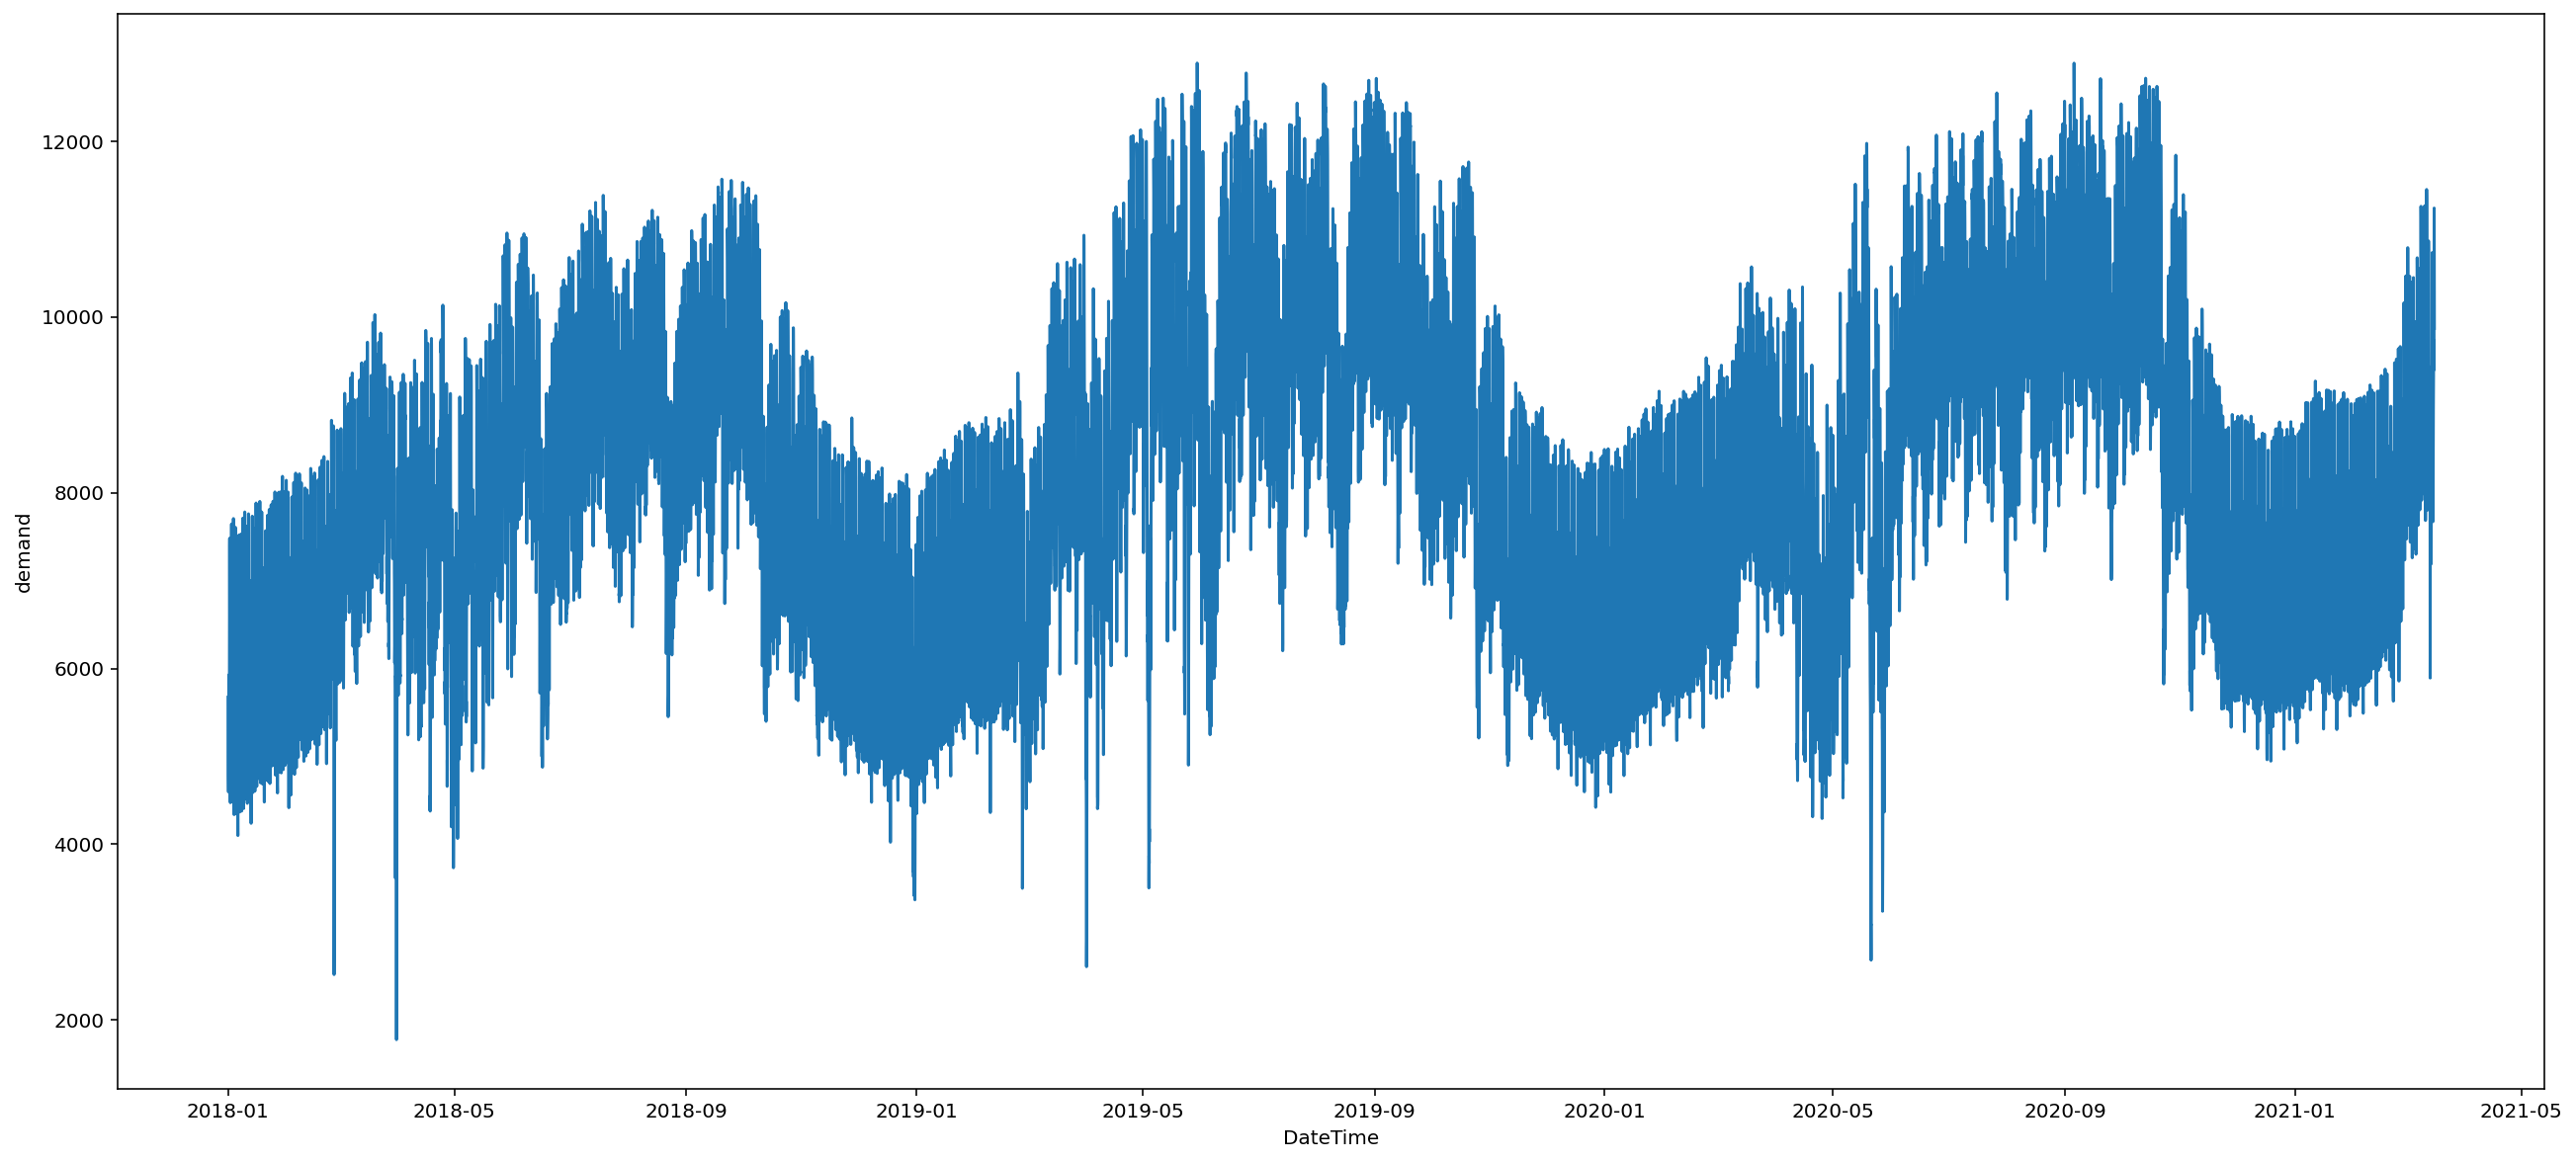

In [12]:
sns.lineplot(x=df.index, y="demand", data=df);

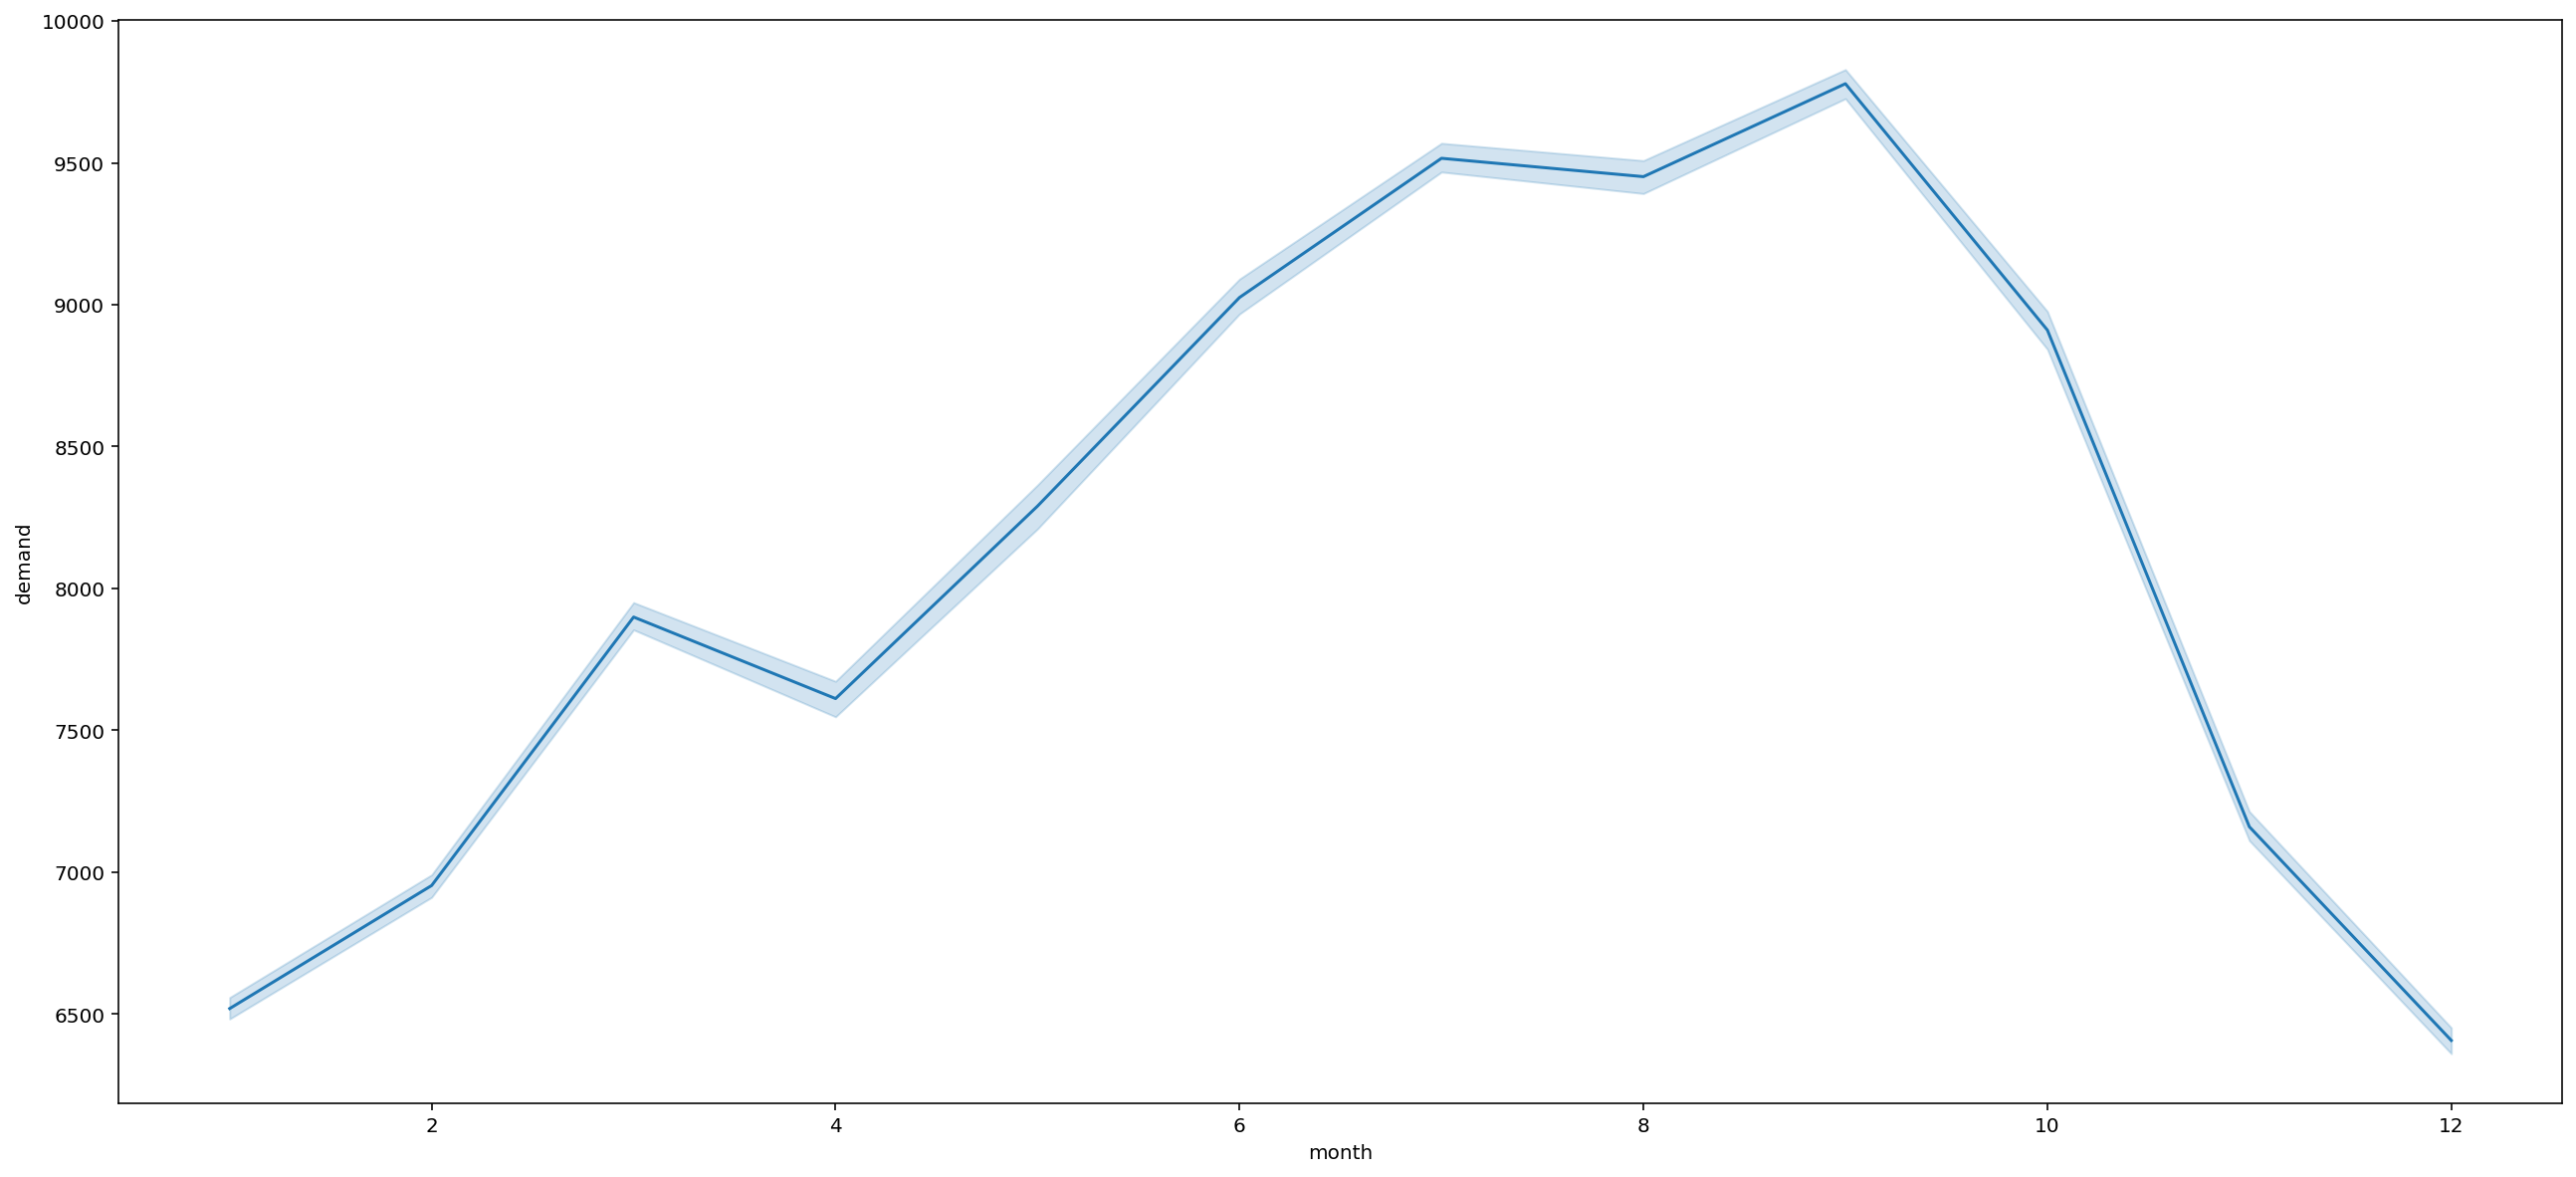

In [13]:
sns.lineplot(x='month', y="demand", data=df);

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed=seasonal_decompose(df["demand"],
                             model='additive'
                             )

In [15]:
trend=decomposed.trend
sesonal=decomposed.seasonal
residual=decomposed.resid

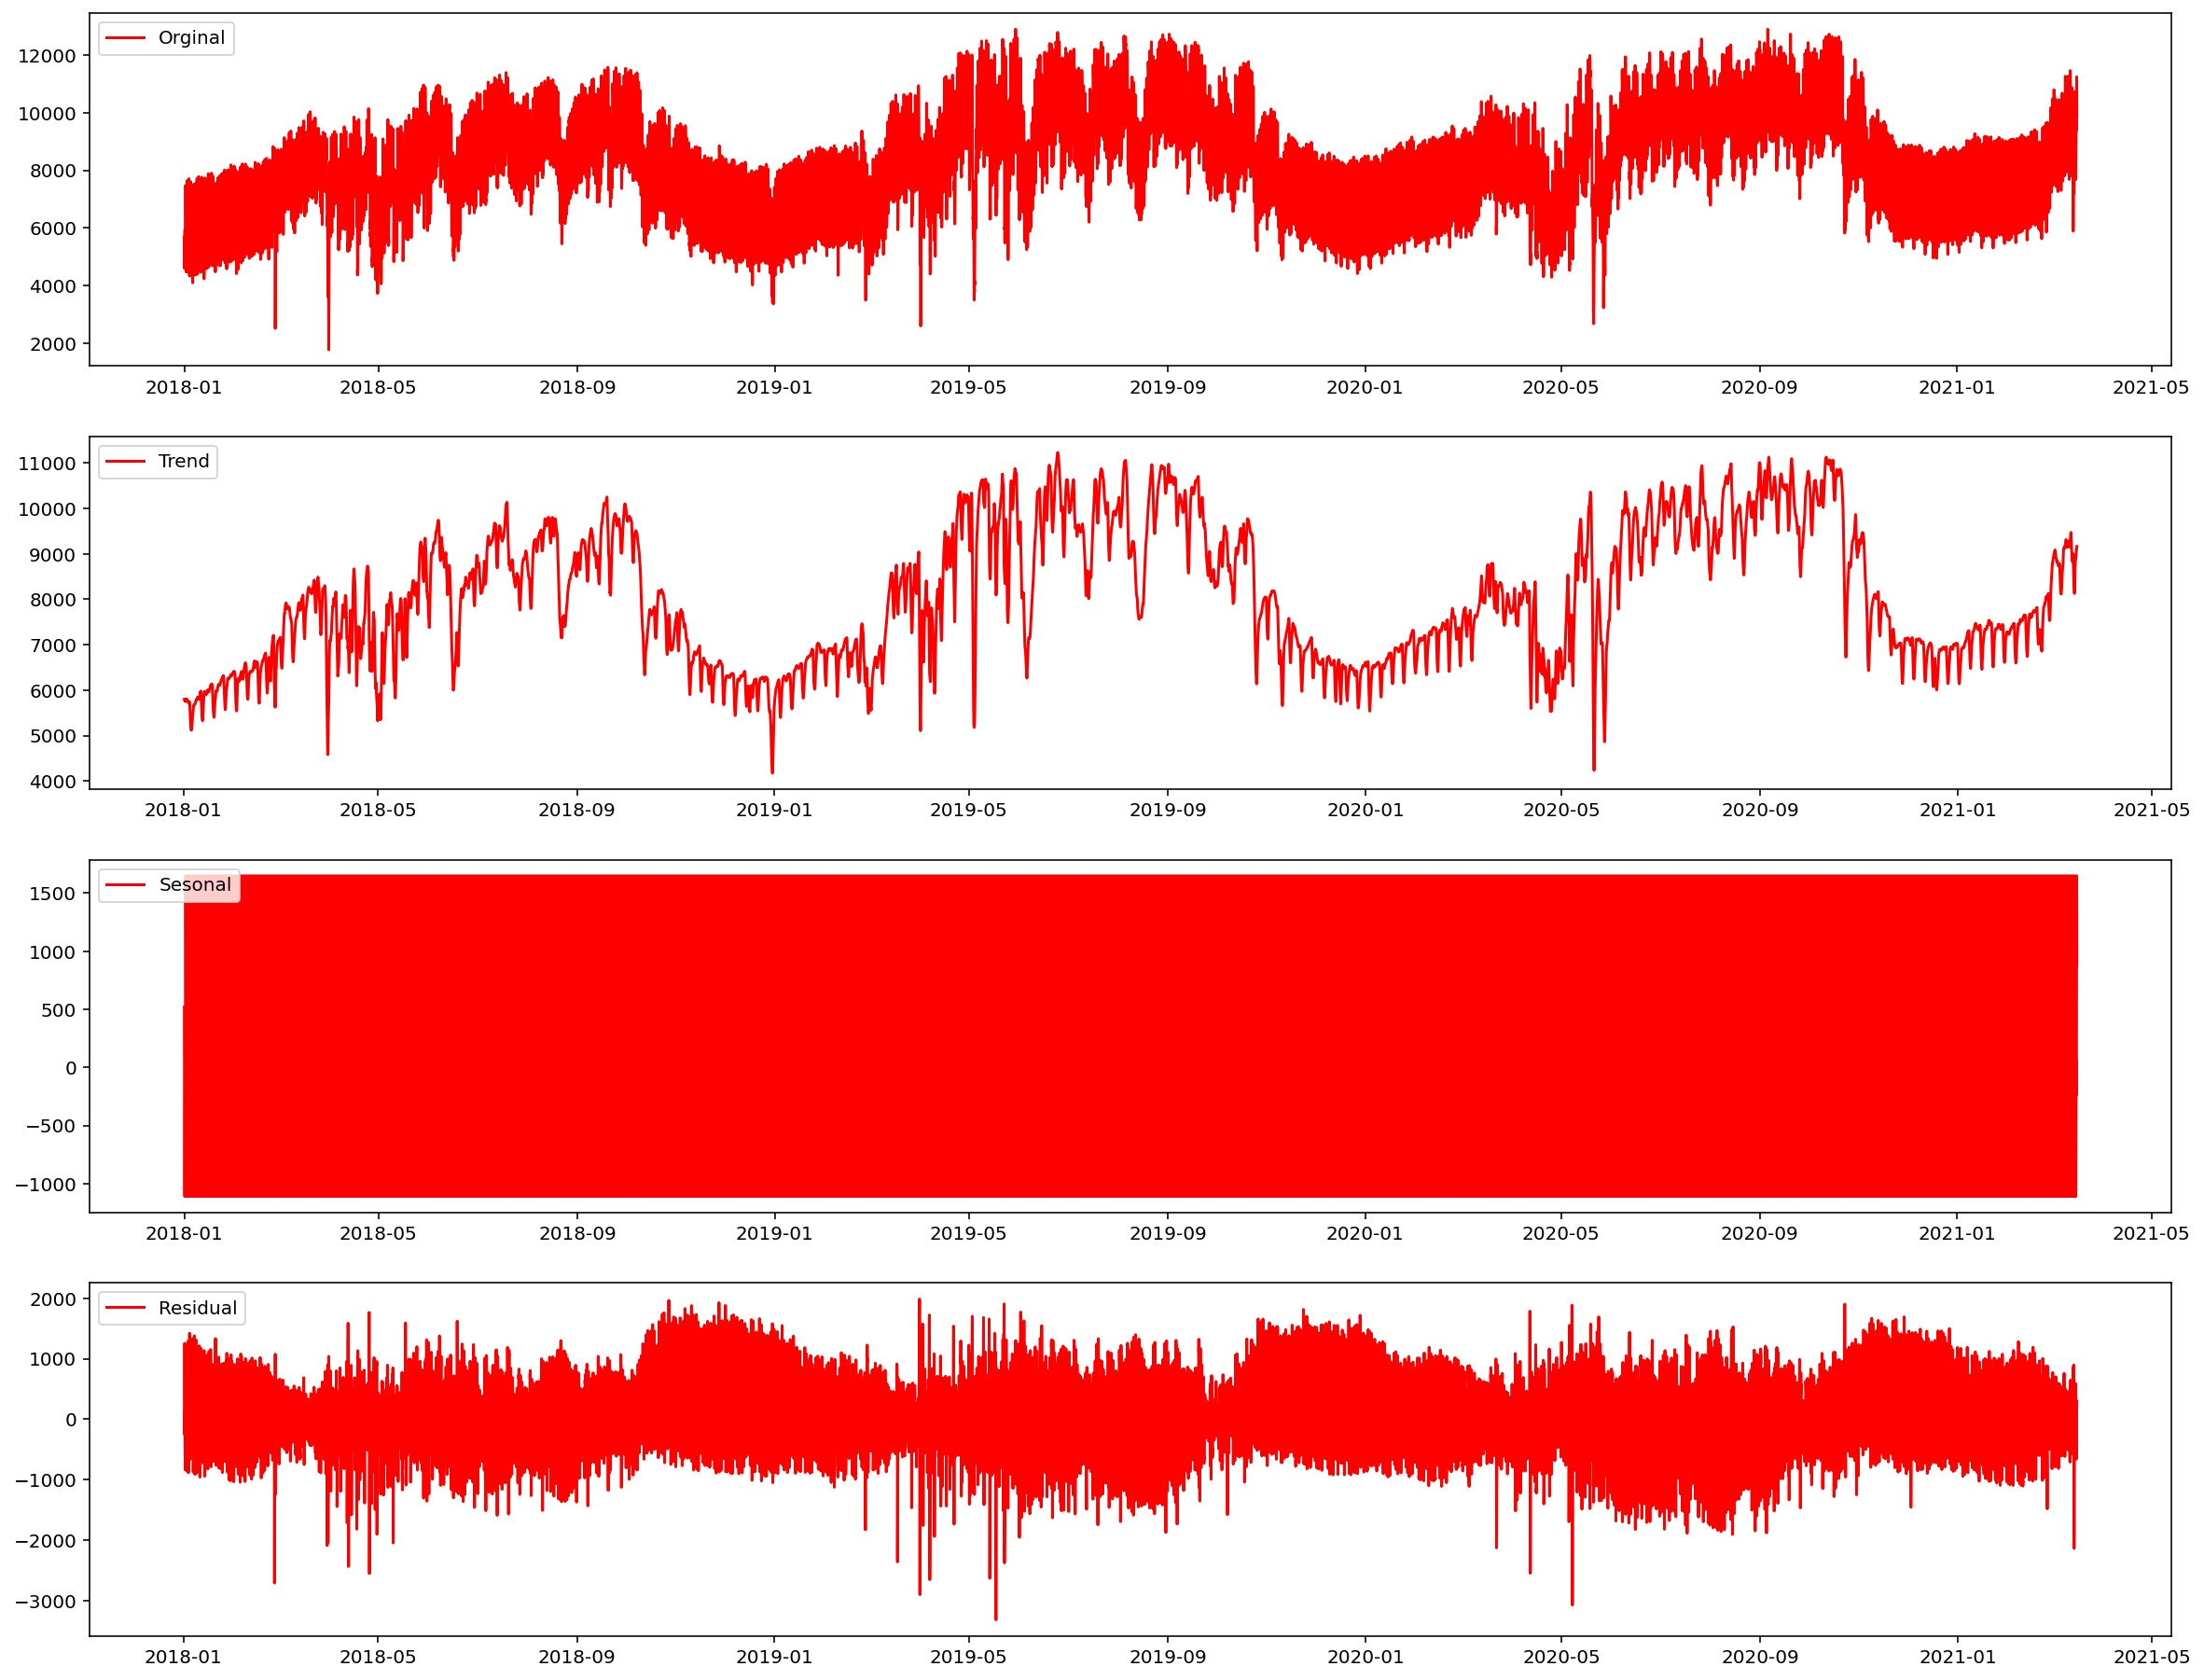

In [16]:
plt.figure(figsize=(20,16))
plt.subplot(411)
plt.plot(df["demand"],label="Orginal",color='red')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend,label="Trend",color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(sesonal,label="Sesonal",color='red')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual,label="Residual",color='red')
plt.legend(loc='upper left')
plt.show()

In [9]:
# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
# X=scaler.fit_transform(df.demand.values.reshape(-1,1))
D_max_daily = df.groupby(df.index).demand.max().to_numpy()
df.demand= df.demand/max(D_max_daily)
D_max=max(D_max_daily)

In [10]:
##splitting dataset into train and test split
training_size=int(len(df)*0.65)
test_size=len(df)-training_size
train_data,test_data=df.demand[0:training_size],df.demand[training_size:len(df)]

In [11]:
train=train_data.values.reshape(-1,1)
test=test_data.values.reshape(-1,1)

In [12]:
train.shape

(18252, 1)

In [13]:
test.shape

(9828, 1)

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 24*7 # take time laps for 7 days
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)

In [16]:
print(X_train.shape)
print(y_train.shape)

(18083, 168)
(18083,)


In [17]:
print(X_test.shape)
print(ytest.shape)

(9659, 168)
(9659,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [19]:
#print(X_train[:3])
#print(y_train[:3])
#print(X_test.shape)
#print(len(X_train[1]))
print(X_train[0])

[[0.4400062 ]
 [0.40200109]
 [0.38067168]
 [0.37120918]
 [0.35670519]
 [0.35631738]
 [0.37710385]
 [0.40262158]
 [0.43395641]
 [0.45970682]
 [0.44365159]
 [0.446056  ]
 [0.45024432]
 [0.45520825]
 [0.43201737]
 [0.4321725 ]
 [0.43038858]
 [0.45869852]
 [0.5668192 ]
 [0.57360583]
 [0.58039246]
 [0.55890793]
 [0.51260374]
 [0.47863182]
 [0.43054371]
 [0.3909098 ]
 [0.36291011]
 [0.3564725 ]
 [0.34840611]
 [0.34685488]
 [0.3655472 ]
 [0.39641666]
 [0.43845498]
 [0.45032188]
 [0.44528038]
 [0.44093694]
 [0.45326922]
 [0.45986194]
 [0.44194524]
 [0.44559063]
 [0.44070426]
 [0.47351276]
 [0.5654231 ]
 [0.57919026]
 [0.59295742]
 [0.56480261]
 [0.5221438 ]
 [0.45924145]
 [0.42309781]
 [0.39789033]
 [0.37144187]
 [0.36686574]
 [0.34770806]
 [0.3520515 ]
 [0.36764136]
 [0.39292639]
 [0.4291476 ]
 [0.45978438]
 [0.44915846]
 [0.43232762]
 [0.44326379]
 [0.45164043]
 [0.42674319]
 [0.4400062 ]
 [0.44210036]
 [0.46342977]
 [0.56759482]
 [0.58268052]
 [0.59776623]
 [0.57915148]
 [0.51880866]
 [0.45

In [20]:
X_train

array([[[0.4400062 ],
        [0.40200109],
        [0.38067168],
        ...,
        [0.55247033],
        [0.50888079],
        [0.45559606]],

       [[0.40200109],
        [0.38067168],
        [0.37120918],
        ...,
        [0.50888079],
        [0.45559606],
        [0.41503141]],

       [[0.38067168],
        [0.37120918],
        [0.35670519],
        ...,
        [0.45559606],
        [0.41503141],
        [0.37702629]],

       ...,

       [[0.45280385],
        [0.46622198],
        [0.45365702],
        ...,
        [0.43915303],
        [0.45094237],
        [0.47925231]],

       [[0.46622198],
        [0.45365702],
        [0.44791747],
        ...,
        [0.45094237],
        [0.47925231],
        [0.50042659]],

       [[0.45365702],
        [0.44791747],
        [0.46342977],
        ...,
        [0.47925231],
        [0.50042659],
        [0.51826573]]])

In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional,GRU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard

from keras.layers import TimeDistributed


In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_absolute_percentage_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 168, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 168, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
import time
start_time = time.time()
history=model.fit(X_train,y_train,epochs = 30, batch_size=64,validation_split=0.1)
finish_time = time.time()
print("--- %s seconds ---" % (finish_time - start_time))

Epoch 1/30
255/255 [==============================] - 82s 323ms/step - loss: 13.3997 - val_loss: 9.9201
Epoch 2/30
255/255 [==============================] - 132s 519ms/step - loss: 8.3028 - val_loss: 9.3284
Epoch 3/30
255/255 [==============================] - 86s 336ms/step - loss: 6.6102 - val_loss: 4.9213
Epoch 4/30
255/255 [==============================] - 70s 274ms/step - loss: 5.6707 - val_loss: 4.4709
Epoch 5/30
255/255 [==============================] - 95s 372ms/step - loss: 5.0729 - val_loss: 4.4405
Epoch 6/30
255/255 [==============================] - 112s 441ms/step - loss: 4.5915 - val_loss: 3.7839
Epoch 7/30
255/255 [==============================] - 142s 558ms/step - loss: 3.9489 - val_loss: 4.3295
Epoch 8/30
255/255 [==============================] - 167s 655ms/step - loss: 3.4853 - val_loss: 3.0495
Epoch 9/30
255/255 [==============================] - 93s 363ms/step - loss: 3.1655 - val_loss: 2.8047
Epoch 10/30
255/255 [==============================] - 83s 327ms/ste

In [25]:
print((finish_time - start_time)/60,'minutes')
scores = model.evaluate(X_test, ytest)
print("TEST MAPE :",scores)

54.69466195901235 minutes
302/302 [==============================] - 32s 104ms/step - loss: 2.6371
TEST MAPE : 2.6370646953582764


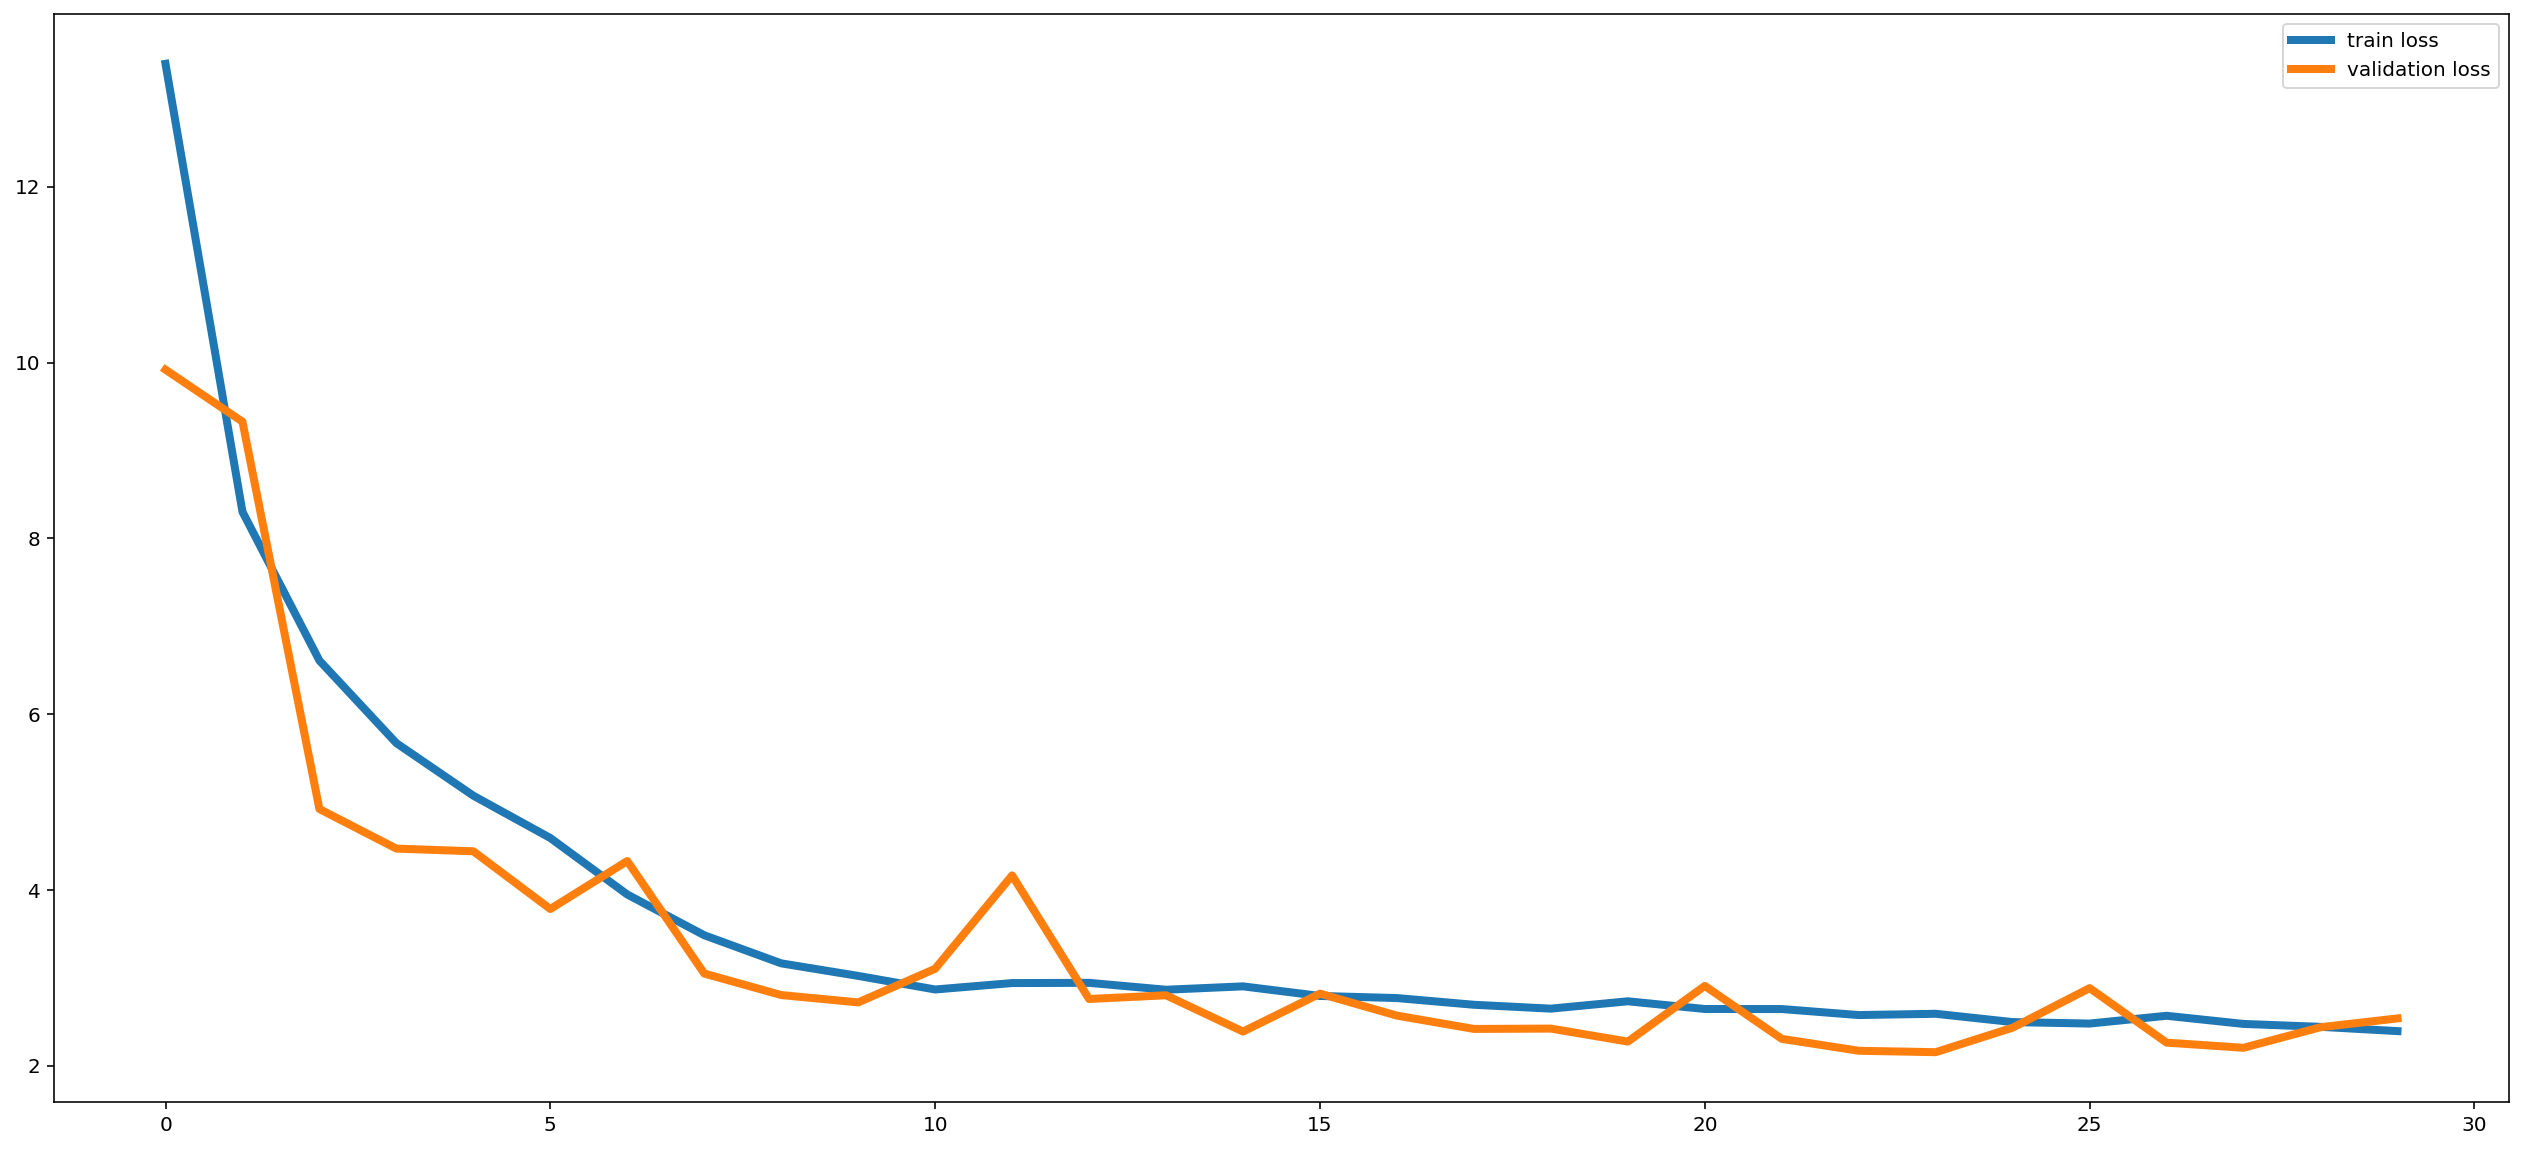

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], linewidth =4)
plt.plot(history.history['val_loss'], linewidth =4)
#plt.grid(False)
a =  plt.legend(['train loss','validation loss'])



plt.show()

In [27]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train*D_max,train_predict*D_max))

277.0443007769521

In [29]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest*D_max,test_predict*D_max))

294.59176652135176

In [30]:
train_predict.shape

(18083, 1)

In [31]:
y_train_rs=y_train.reshape(-1,1)
y_train_rs.shape

(18083, 1)

In [32]:
df.demand.shape

(28080,)

In [33]:
train_predict.shape

(18083, 1)

In [34]:
test_predict.shape

(9659, 1)

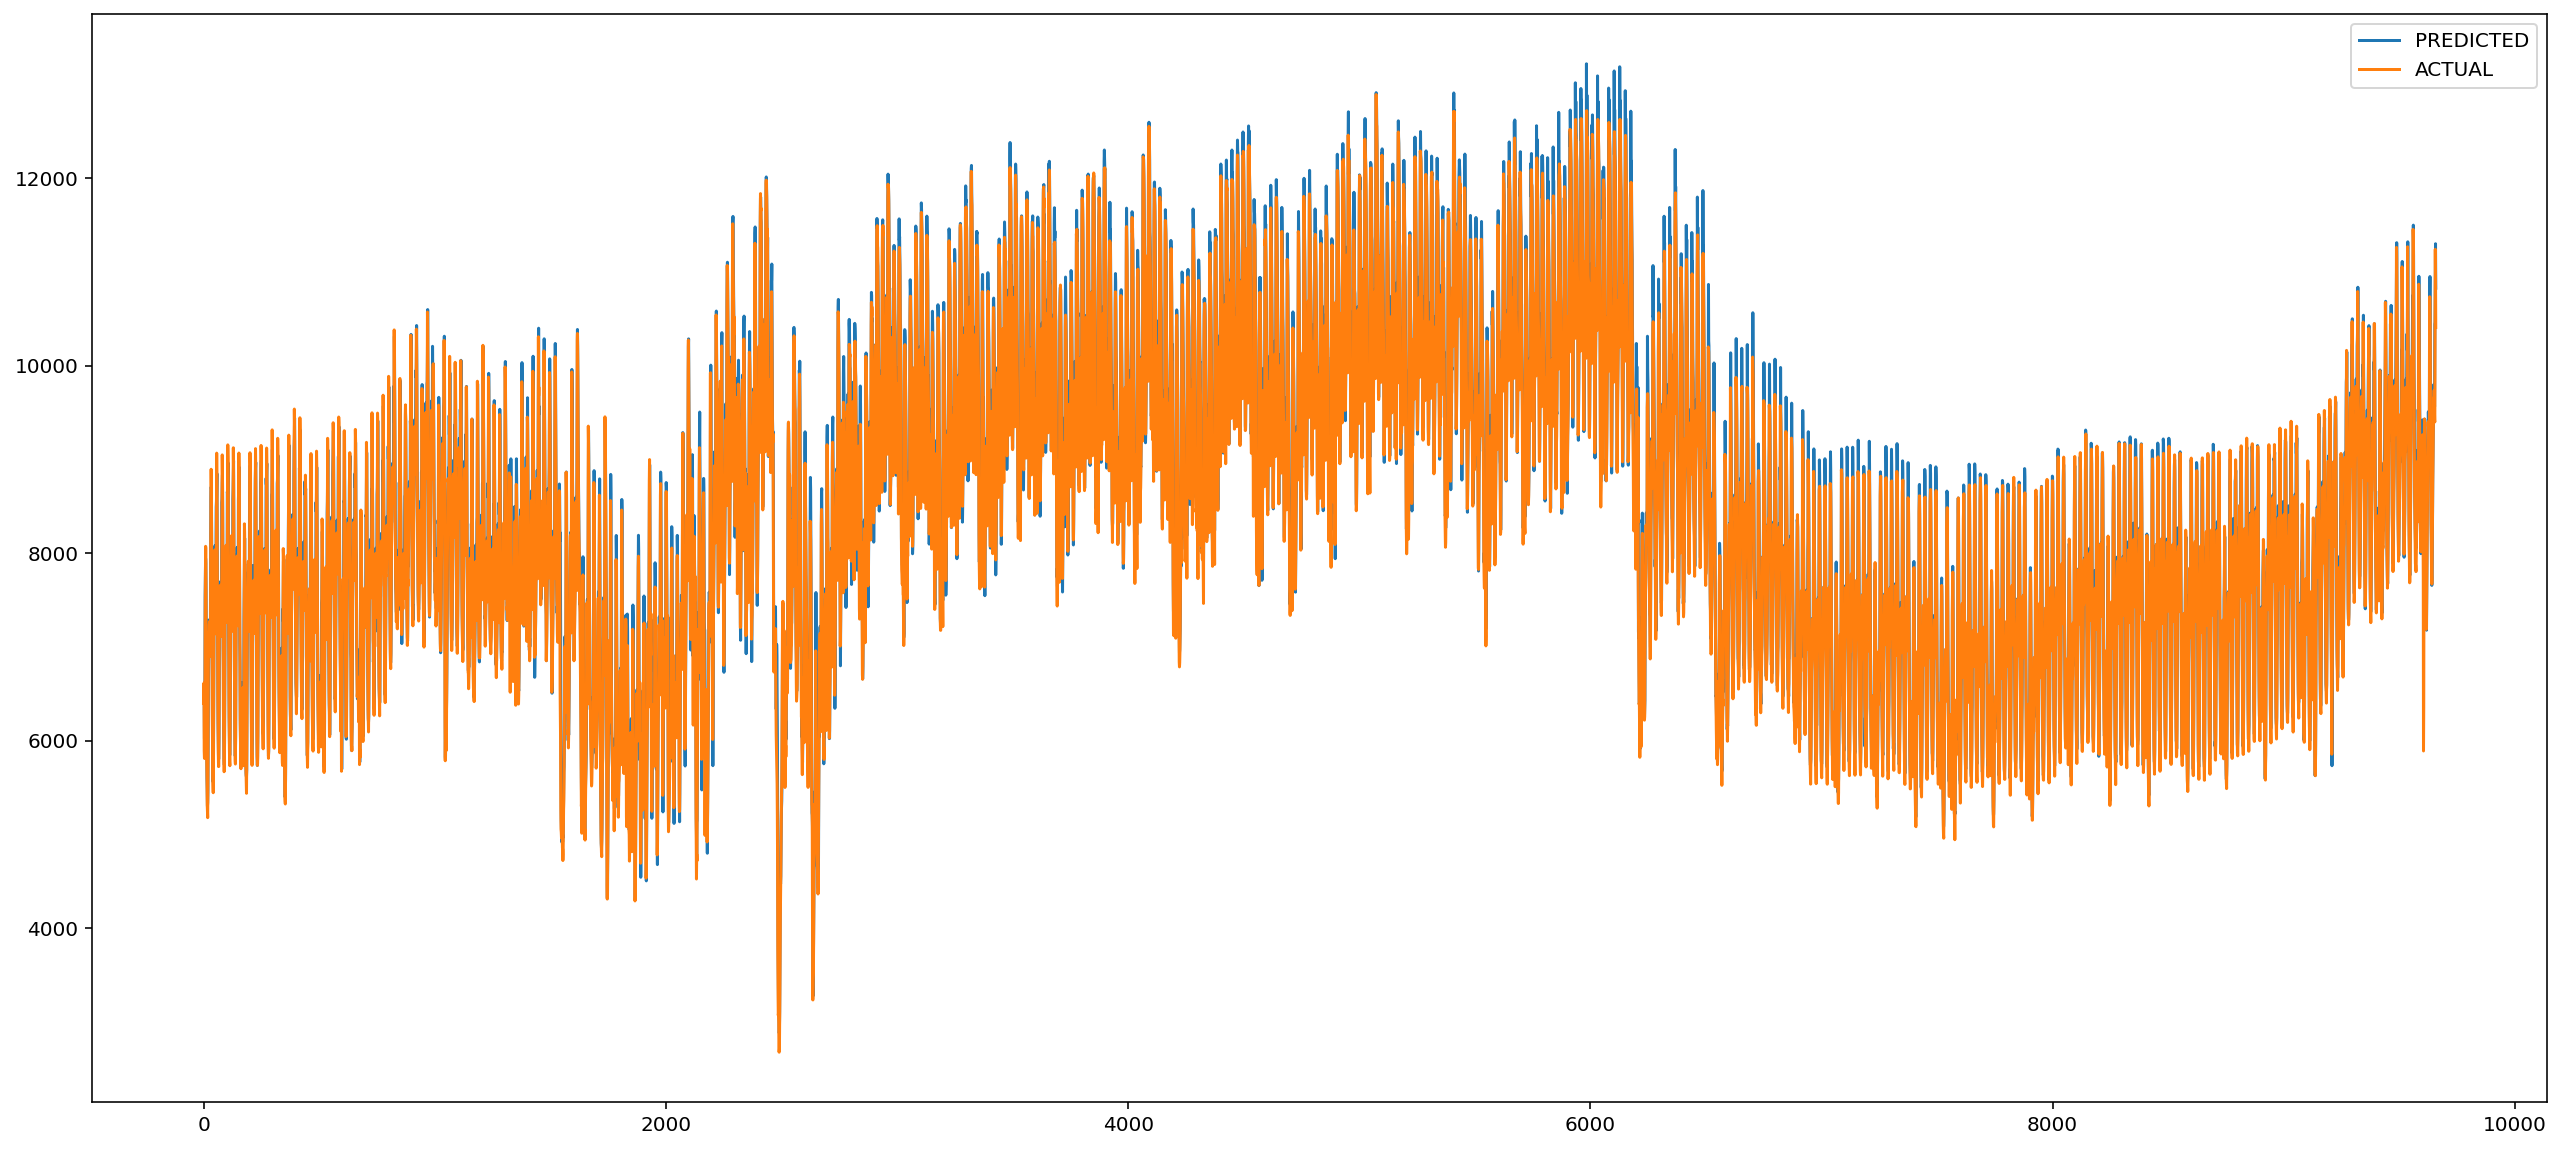

In [35]:
plt.plot(test_predict*D_max)
plt.plot(ytest*D_max)
plt.legend(['PREDICTED','ACTUAL'])

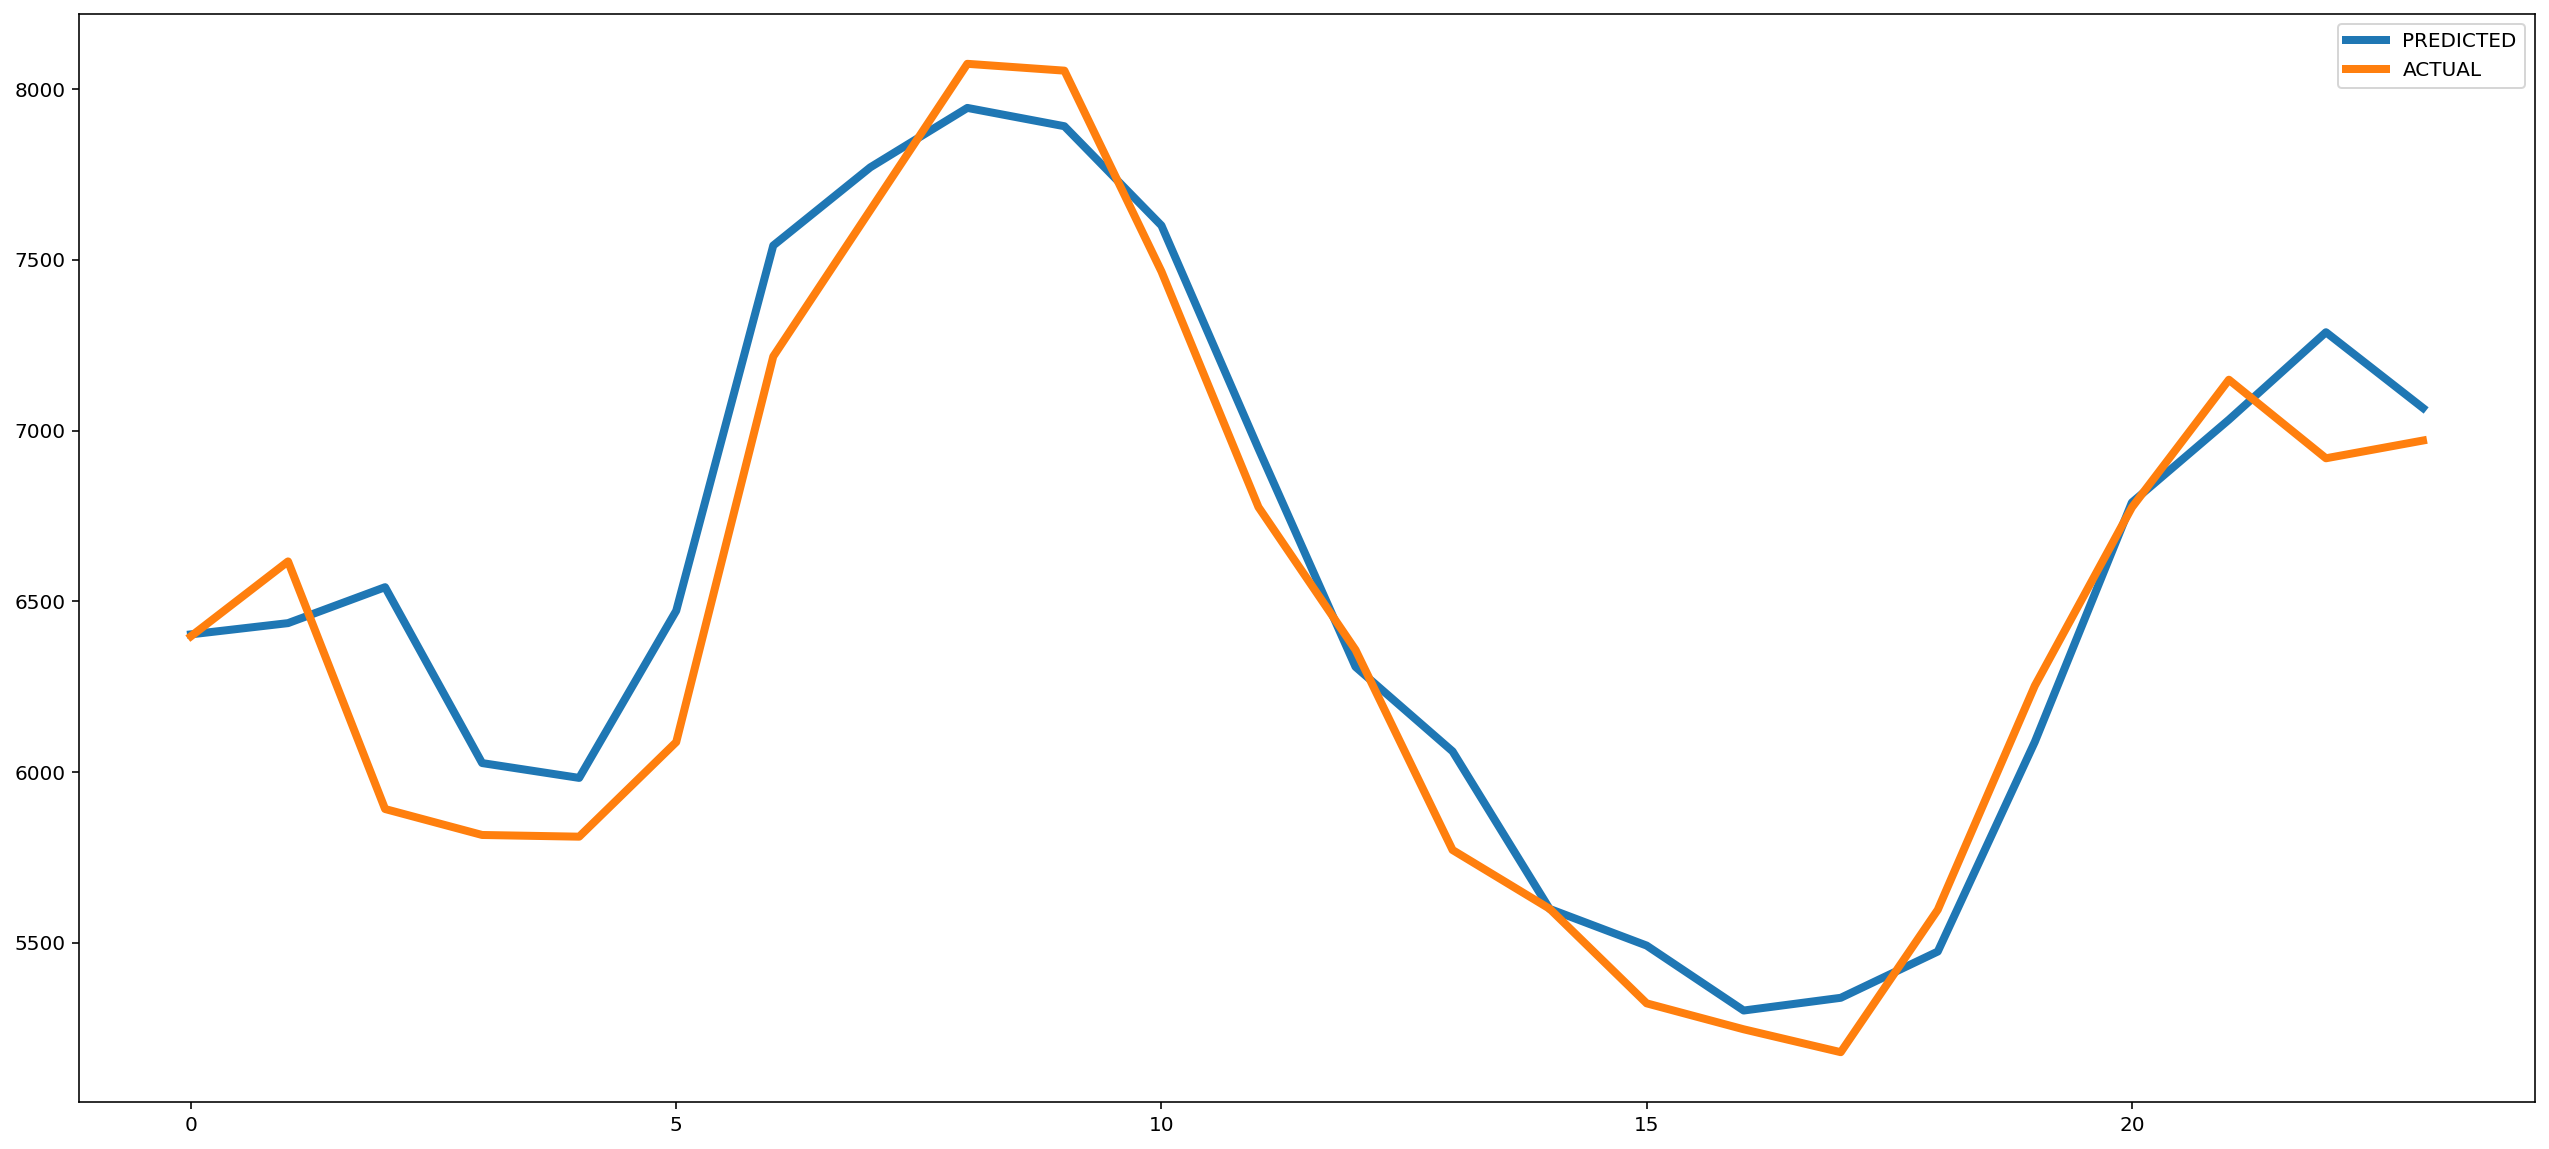

In [36]:
plt.plot(test_predict[:24]*D_max, linewidth = 4)
plt.plot(ytest[:24]*D_max, linewidth = 4)
plt.grid(False)
plt.legend(['PREDICTED','ACTUAL'])


In [37]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

In [38]:
from sklearn.ensemble import RandomForestRegressor
cls = RandomForestRegressor(n_estimators=1,min_samples_leaf=100)
cls.fit(d2_train_dataset,y_train)

RandomForestRegressor(min_samples_leaf=100, n_estimators=1)

In [39]:
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

In [40]:
sk_pred=cls.predict(d2_test_dataset)

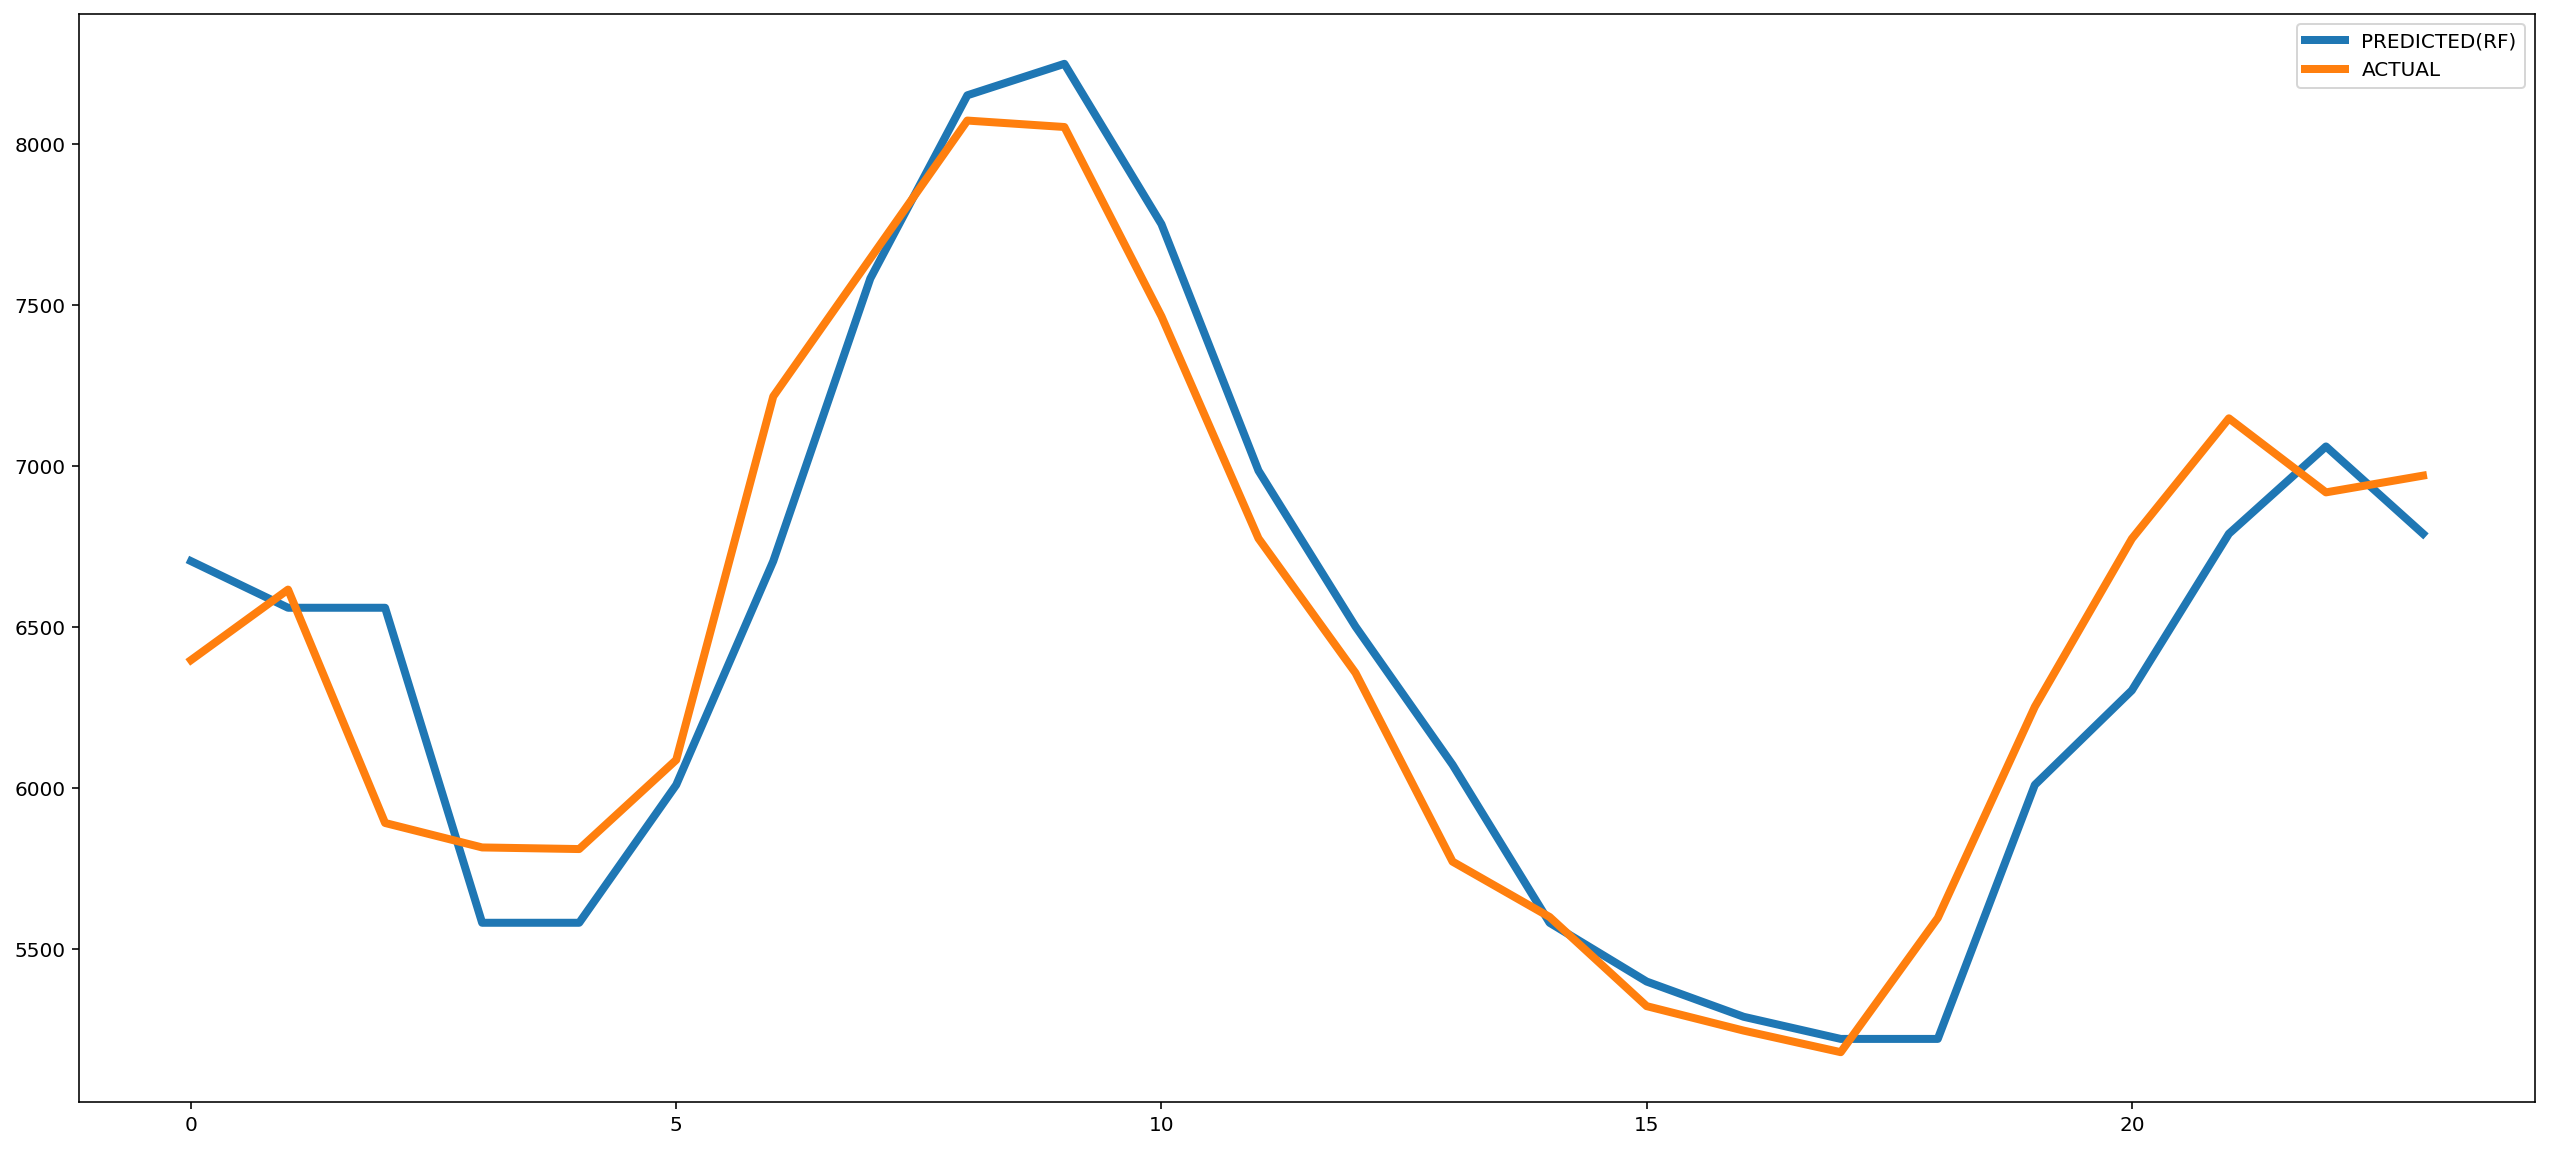

In [41]:
plt.plot(sk_pred[0:24]*D_max, linewidth = 4)
plt.plot(ytest[0:24]*D_max, linewidth = 4)
plt.grid(False)

plt.legend(['PREDICTED(RF)','ACTUAL'])

In [42]:
import sklearn.metrics
from sklearn.metrics import mean_squared_error

In [43]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [44]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

3.375798948058543

In [45]:
cls.score(d2_test_dataset,ytest)

0.9528331839565265

In [46]:
cls.feature_importances_

array([0.00000000e+00, 3.76304993e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06519902e-04,
       2.96964746e-04, 5.16745161e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.33248178e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.01018505e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [47]:
importance = cls.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00376
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00021
Feature: 20, Score: 0.00030
Feature: 21, Score: 0.00005
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00013
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

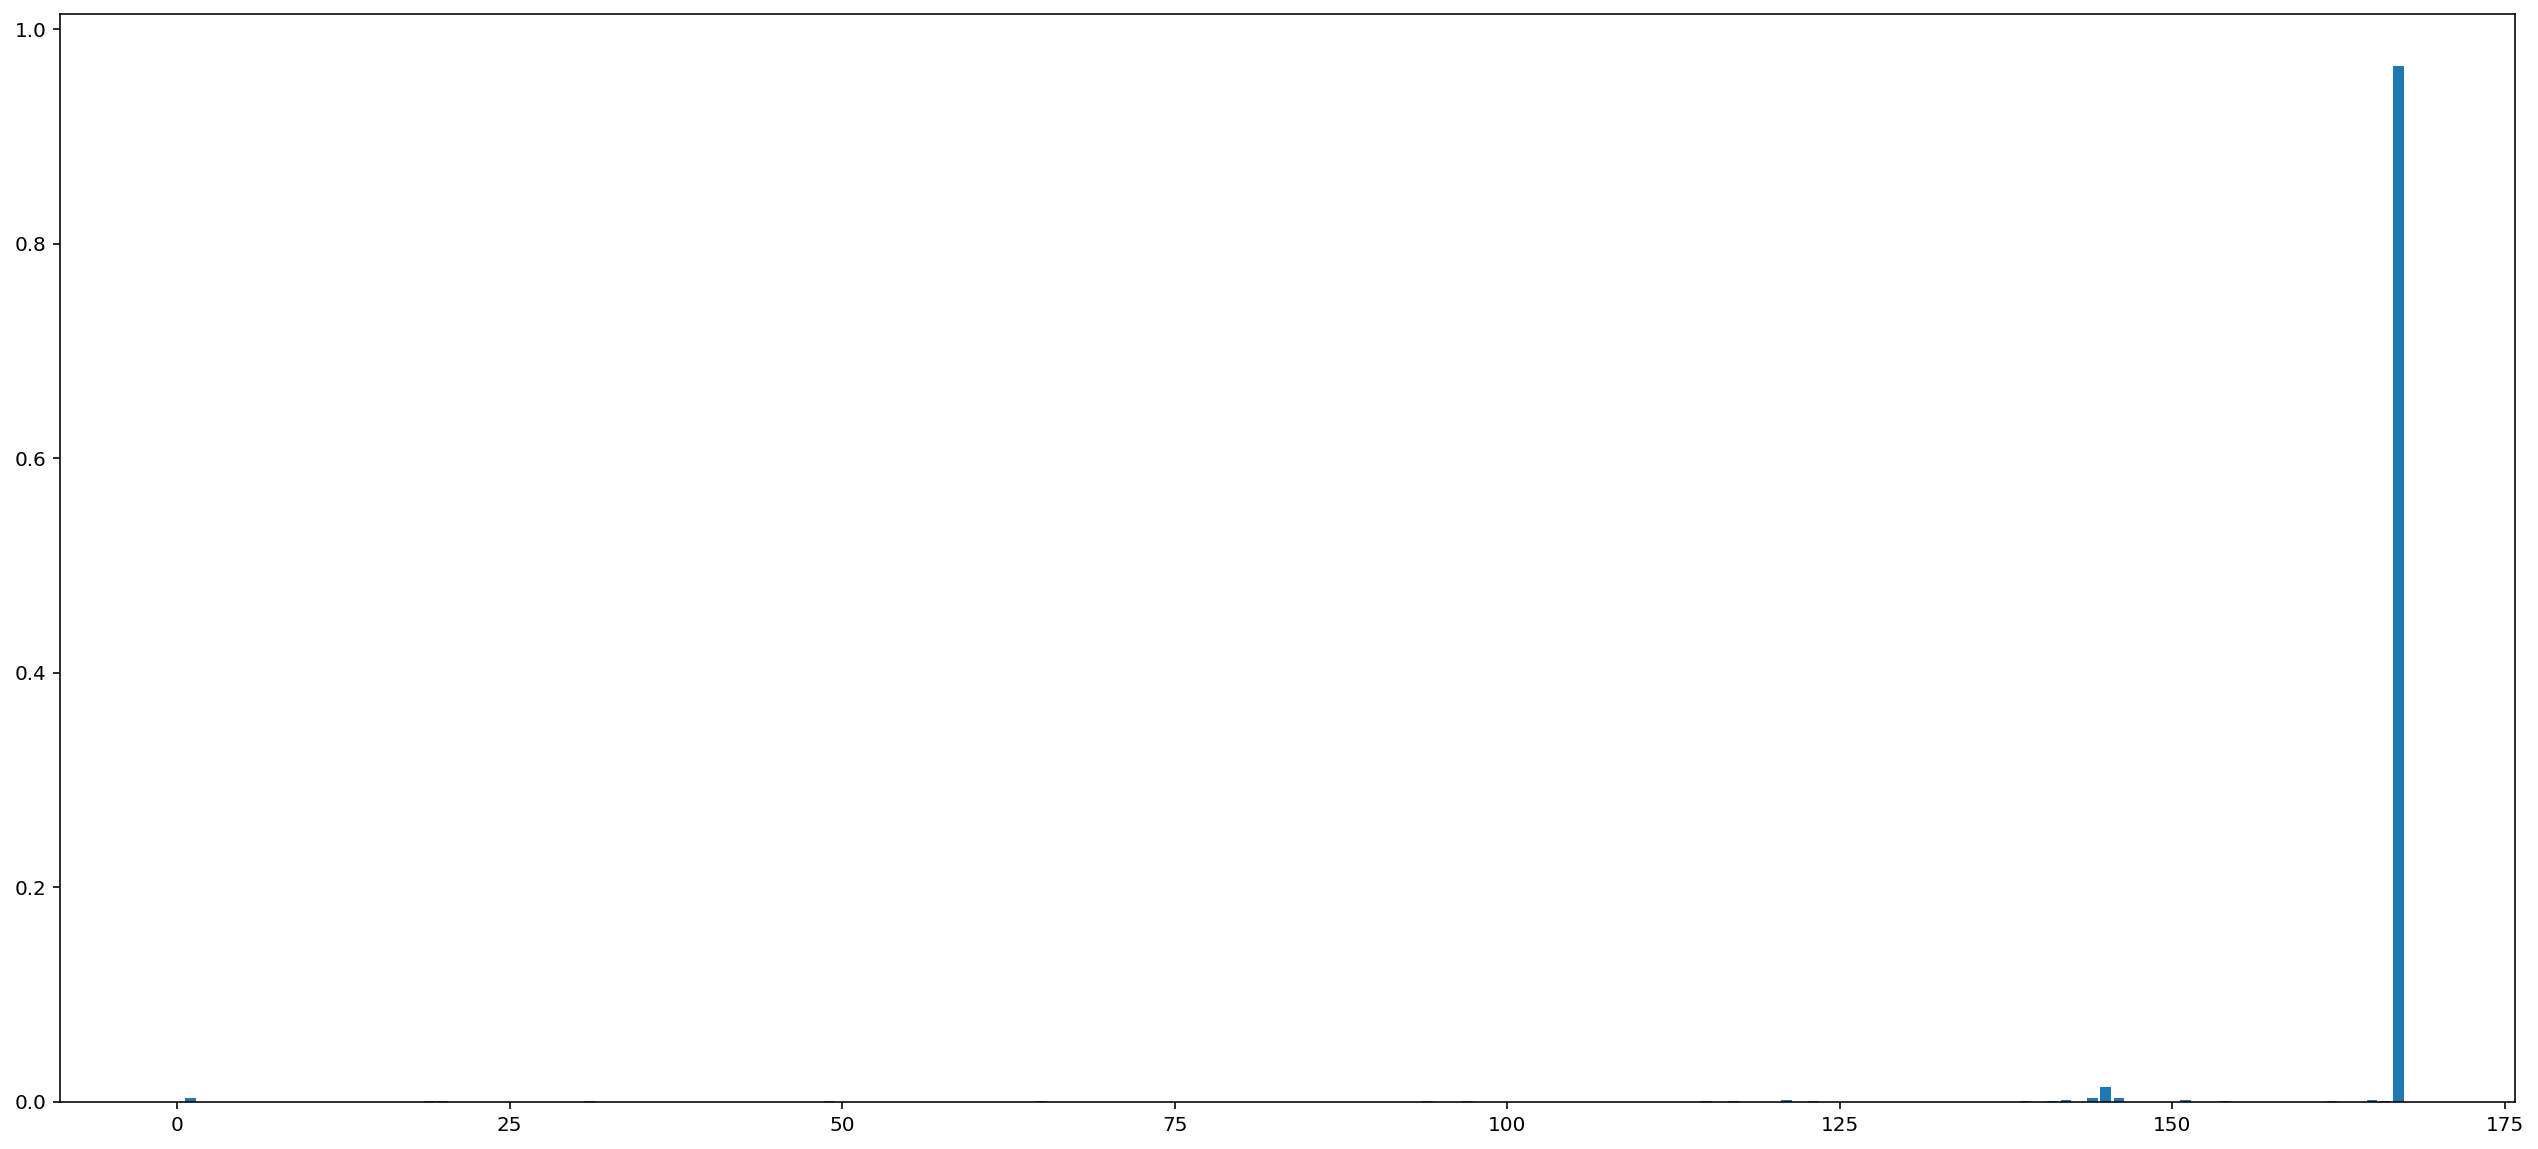

In [48]:
from matplotlib import pyplot
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [49]:
cls.feature_importances_

array([0.00000000e+00, 3.76304993e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.06519902e-04,
       2.96964746e-04, 5.16745161e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.33248178e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.01018505e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [50]:
# Main function for calculating Mean Absolute Percentage Error
import sklearn.metrics
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [51]:
MAPE_RF=mean_absolute_percentage_error(ytest,sk_pred)
MAPE_RF

3.375798948058543

In [52]:
cls.score(d2_test_dataset,ytest)

0.9528331839565265

In [53]:
# #Function for calculating LSTM model MAPE value
# def LSTM_MAEP_RMSE(month,year):
#   year_dict = {2018: 1, 2019: 2, 2020: 3}

#   month_seq = {
#       "jan": 1,
#       "feb": 2,
#       "mar": 3,
#       "apr": 4,
#       "may": 5,
#       "jun": 6,
#       "jul": 7,
#       "aug": 8,
#       "sep": 9,
#       "oct": 10,
#       "nov": 11,
#       "dec": 12,
#   }

#   month_dict = {
#       "jan": (0, 31),
#       "feb": (31, 59),
#       "mar": (59, 90),
#       "apr": (90, 120),
#       "may": (120, 151),
#       "jun": (151, 181),
#       "jul": (181, 212),
#       "aug": (212, 243),
#       "sep": (243, 273),
#       "oct": (273, 304),
#       "nov": (304, 334),
#       "dec": (334, 365)
#   } 

#   st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
#   en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
#   test_y_jan = []
#   true_y_jan = []
#   for i in range(st, en):
#       test = X_train[i]
#       true_y_jan.append(ytest[i])
#       test = test.reshape(1,1,5)
#       y = model.predict(test)
#       test_y_jan.append(y[0][0])
#   return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [54]:
# #Function for calculating RF model MAPE value
# def RF_MAPE_RMSE(month,year):
#   year_dict = {2018: 1, 2019: 2, 2020: 3}

#   month_seq = {
#       "jan": 1,
#       "feb": 2,
#       "mar": 3,
#       "apr": 4,
#       "may": 5,
#       "jun": 6,
#       "jul": 7,
#       "aug": 8,
#       "sep": 9,
#       "oct": 10,
#       "nov": 11,
#       "dec": 12,
#   }

#   month_dict = {
#       "jan": (0, 31),
#       "feb": (31, 59),
#       "mar": (59, 90),
#       "apr": (90, 120),
#       "may": (120, 151),
#       "jun": (151, 181),
#       "jul": (181, 212),
#       "aug": (212, 243),
#       "sep": (243, 273),
#       "oct": (273, 304),
#       "nov": (304, 334),
#       "dec": (334, 365)
#   } 

#   st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
#   en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
#   test_y_jan = []
#   true_y_jan = []
#   for i in range(st, en):
#     test = X_train[i]
#     true_y_jan.append(Y[i])
#     test = test.reshape(1,1*5)
#     y = cls.predict(test)
#     test_y_jan.append(y[0])
#   return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [55]:
# JANUARY_LSTM_MAPE=LSTM_MAEP_RMSE("jan",2020)
# MARCH_LSTM_MAPE=LSTM_MAEP_RMSE("mar",2020)
# JUNE_LSTM_MAPE=LSTM_MAEP_RMSE("jun",2020)
# SEPTEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("sep",2020)
# DECEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("dec",2020)

In [56]:
train.shape

(18252, 1)

In [57]:
gData=df.demand.values.reshape(-1,1)

In [58]:
gData[:10]

array([[0.4400062 ],
       [0.40200109],
       [0.38067168],
       [0.37120918],
       [0.35670519],
       [0.35631738],
       [0.37710385],
       [0.40262158],
       [0.43395641],
       [0.45970682]])

In [59]:
gX, gY = create_dataset(gData, time_step)

In [60]:
gX.shape

(27911, 168)

In [61]:
gY.shape

(27911,)

In [62]:
gX =gX.reshape(gX.shape[0],gX.shape[1] , 1)
gX.shape
pred_gX=model.predict(gX)

In [63]:
#Function for calculating LSTM model MAPE value
def LSTM_MAEP_RMSE(month,year):
  year_dict = {2018: 1, 2019: 2, 2020: 3}

  month_seq = {
      "jan": 1,
      "feb": 2,
      "mar": 3,
      "apr": 4,
      "may": 5,
      "jun": 6,
      "jul": 7,
      "aug": 8,
      "sep": 9,
      "oct": 10,
      "nov": 11,
      "dec": 12,
  }

  month_dict = {
      "jan": (0, 31),
      "feb": (31, 59),
      "mar": (59, 90),
      "apr": (90, 120),
      "may": (120, 151),
      "jun": (151, 181),
      "jul": (181, 212),
      "aug": (212, 243),
      "sep": (243, 273),
      "oct": (273, 304),
      "nov": (304, 334),
      "dec": (334, 365)
  } 

  st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
  en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
  test_y_jan = []
  true_y_jan = []
  for i in range(st, en):
    test_y_jan.append(pred_gX[i])
    true_y_jan.append(gY[i])
      
  return mean_absolute_percentage_error(true_y_jan,test_y_jan)

In [64]:
pred_gX.shape

(27911, 1)

In [65]:
gY.shape

(27911,)

In [66]:
JANUARY_LSTM_MAPE=LSTM_MAEP_RMSE("jan",2020)
MARCH_LSTM_MAPE=LSTM_MAEP_RMSE("mar",2020)
JUNE_LSTM_MAPE=LSTM_MAEP_RMSE("jun",2020)
SEPTEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("sep",2020)
DECEMBER_LSTM_MAPE=LSTM_MAEP_RMSE("dec",2020)

In [67]:
print(JANUARY_LSTM_MAPE)
print(JUNE_LSTM_MAPE)
print(DECEMBER_LSTM_MAPE)
print(SEPTEMBER_LSTM_MAPE)
print(DECEMBER_LSTM_MAPE)

2.477459830770972
2.360035821498564
2.499693100434763
2.9015413559262826
2.499693100434763


In [68]:

def LSTM_MONTH_PLOT(month,year):

  year_dict = {2018: 1, 2019: 2, 2020: 3}

  month_seq = {
      "jan": 1,
      "feb": 2,
      "mar": 3,
      "apr": 4,
      "may": 5,
      "jun": 6,
      "jul": 7,
      "aug": 8,
      "sep": 9,
      "oct": 10,
      "nov": 11,
      "dec": 12,
  }

  month_dict = {
      "jan": (0, 31),
      "feb": (31, 59),
      "mar": (59, 90),
      "apr": (90, 120),
      "may": (120, 151),
      "jun": (151, 181),
      "jul": (181, 212),
      "aug": (212, 243),
      "sep": (243, 273),
      "oct": (273, 304),
      "nov": (304, 334),
      "dec": (334, 365)
  } 

  st = year_dict[year]*365+(month_dict[month][0] + (1 if year == 2020 and month_seq[month] > 2 else 0))*24
  en = year_dict[year]*365+(month_dict[month][1] + (1 if year == 2020 and month_seq[month] >= 2 else 0))*24
  test_y = []
  true_y = []
  for i in range(st, en,24):
    test_y.append(pred_gX[i]*D_max)
    true_y.append(gY[i]*D_max)
  
  plt.plot(test_y,linewidth = 4)
  plt.plot(true_y,linewidth = 4) 
  #plt.suptitle(f"{month.upper()} Month prediction comparison")
  plt.legend(["PREDICTED", "ACTUAL"])

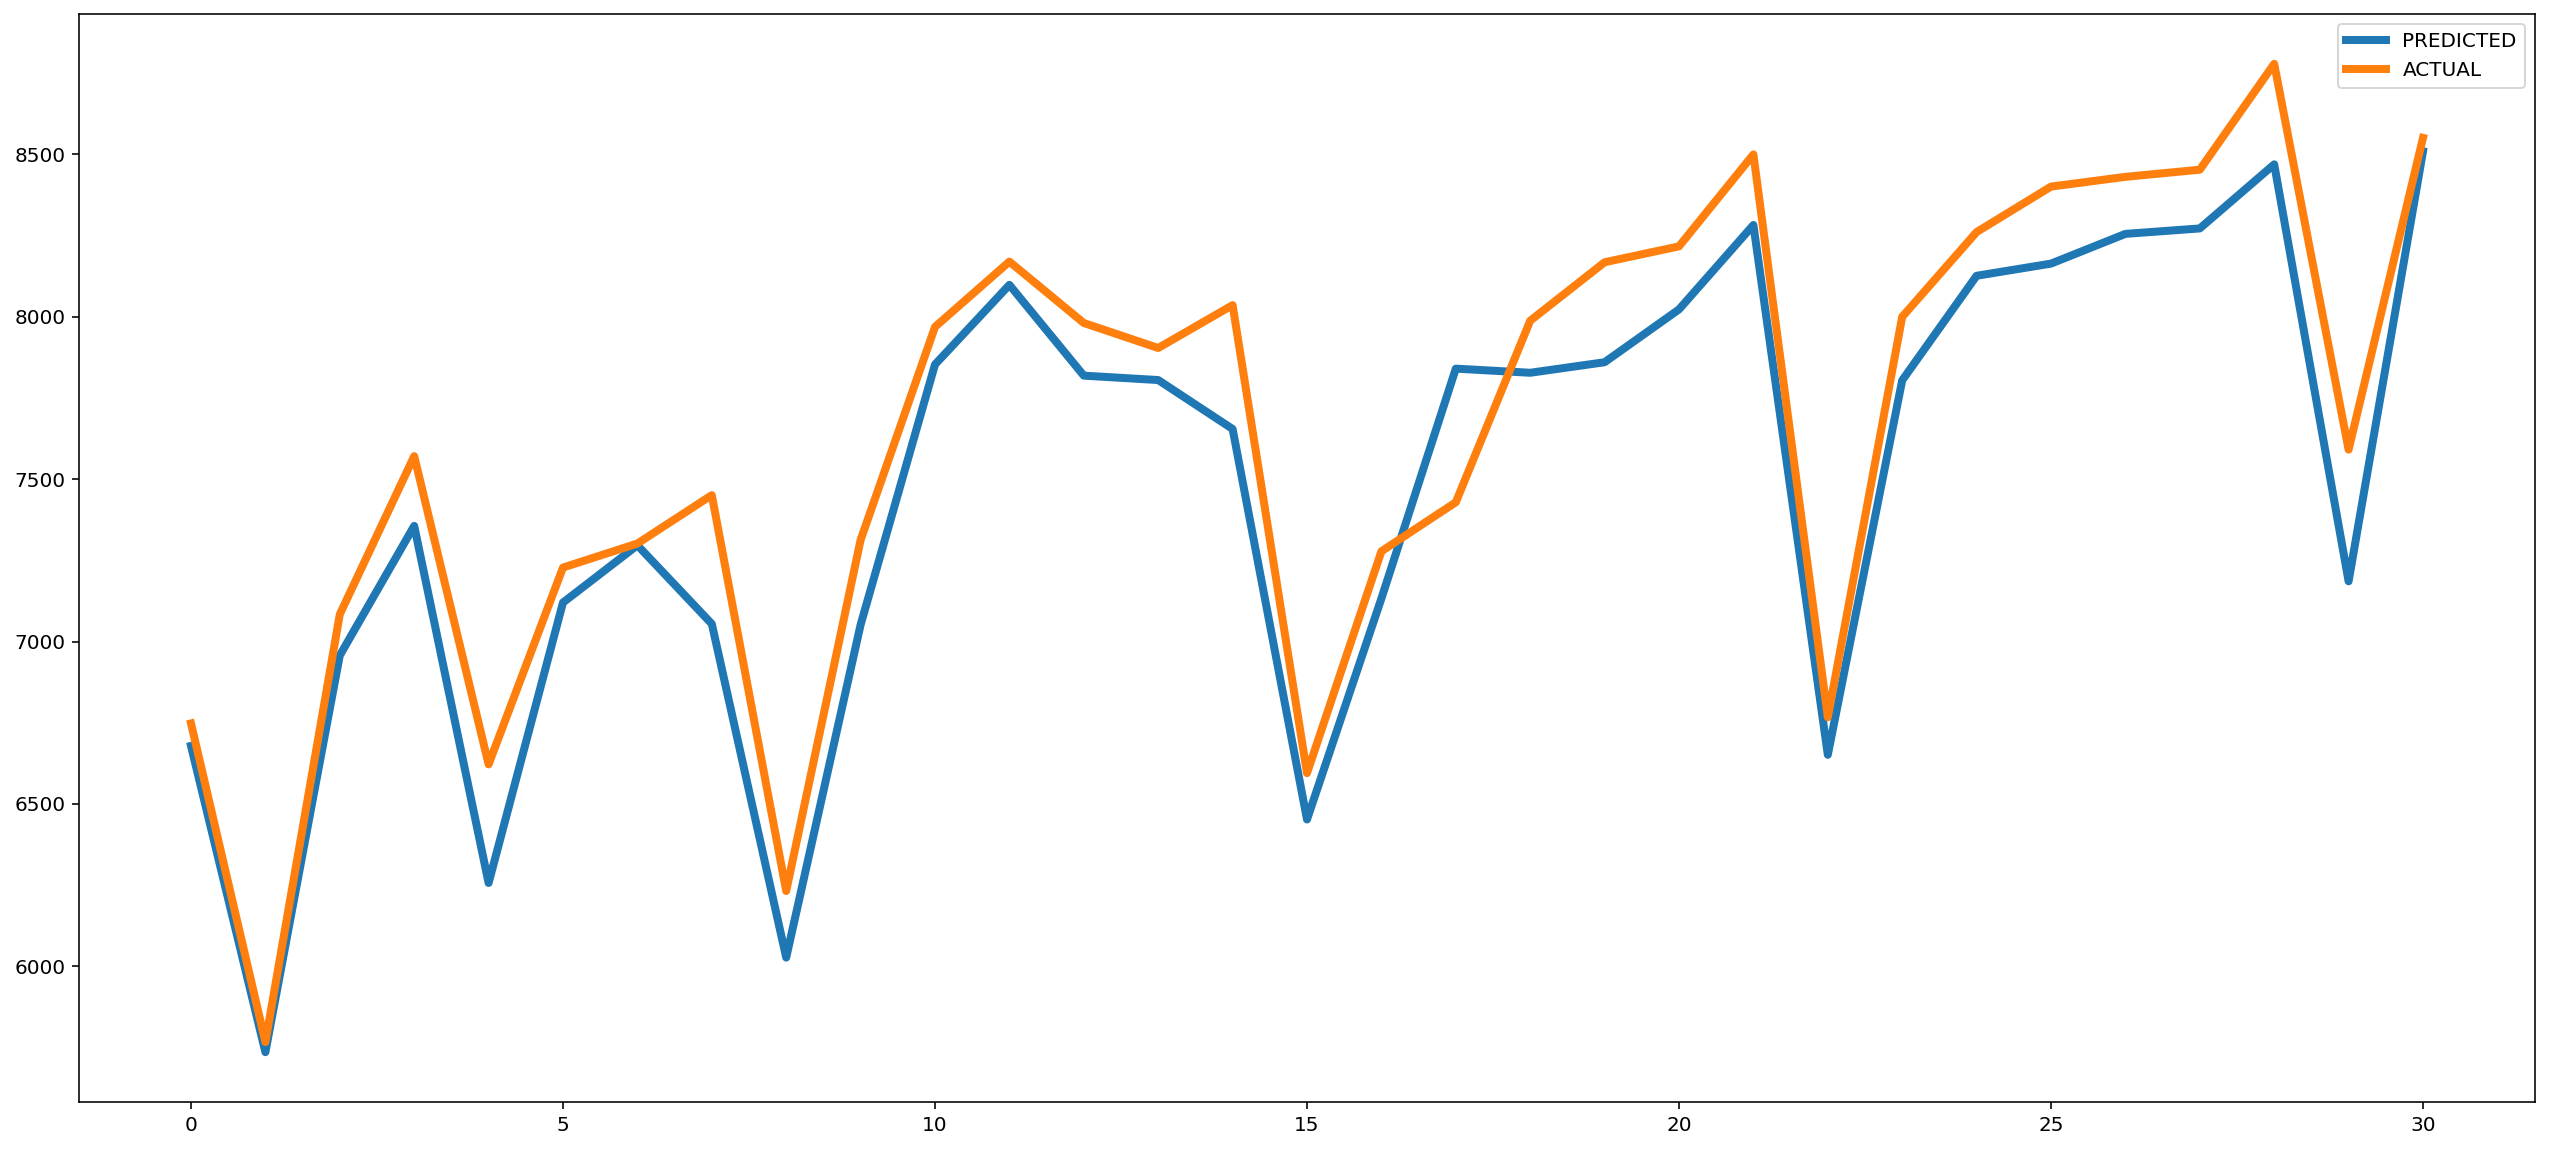

In [69]:
LSTM_MONTH_PLOT('jan',2020)



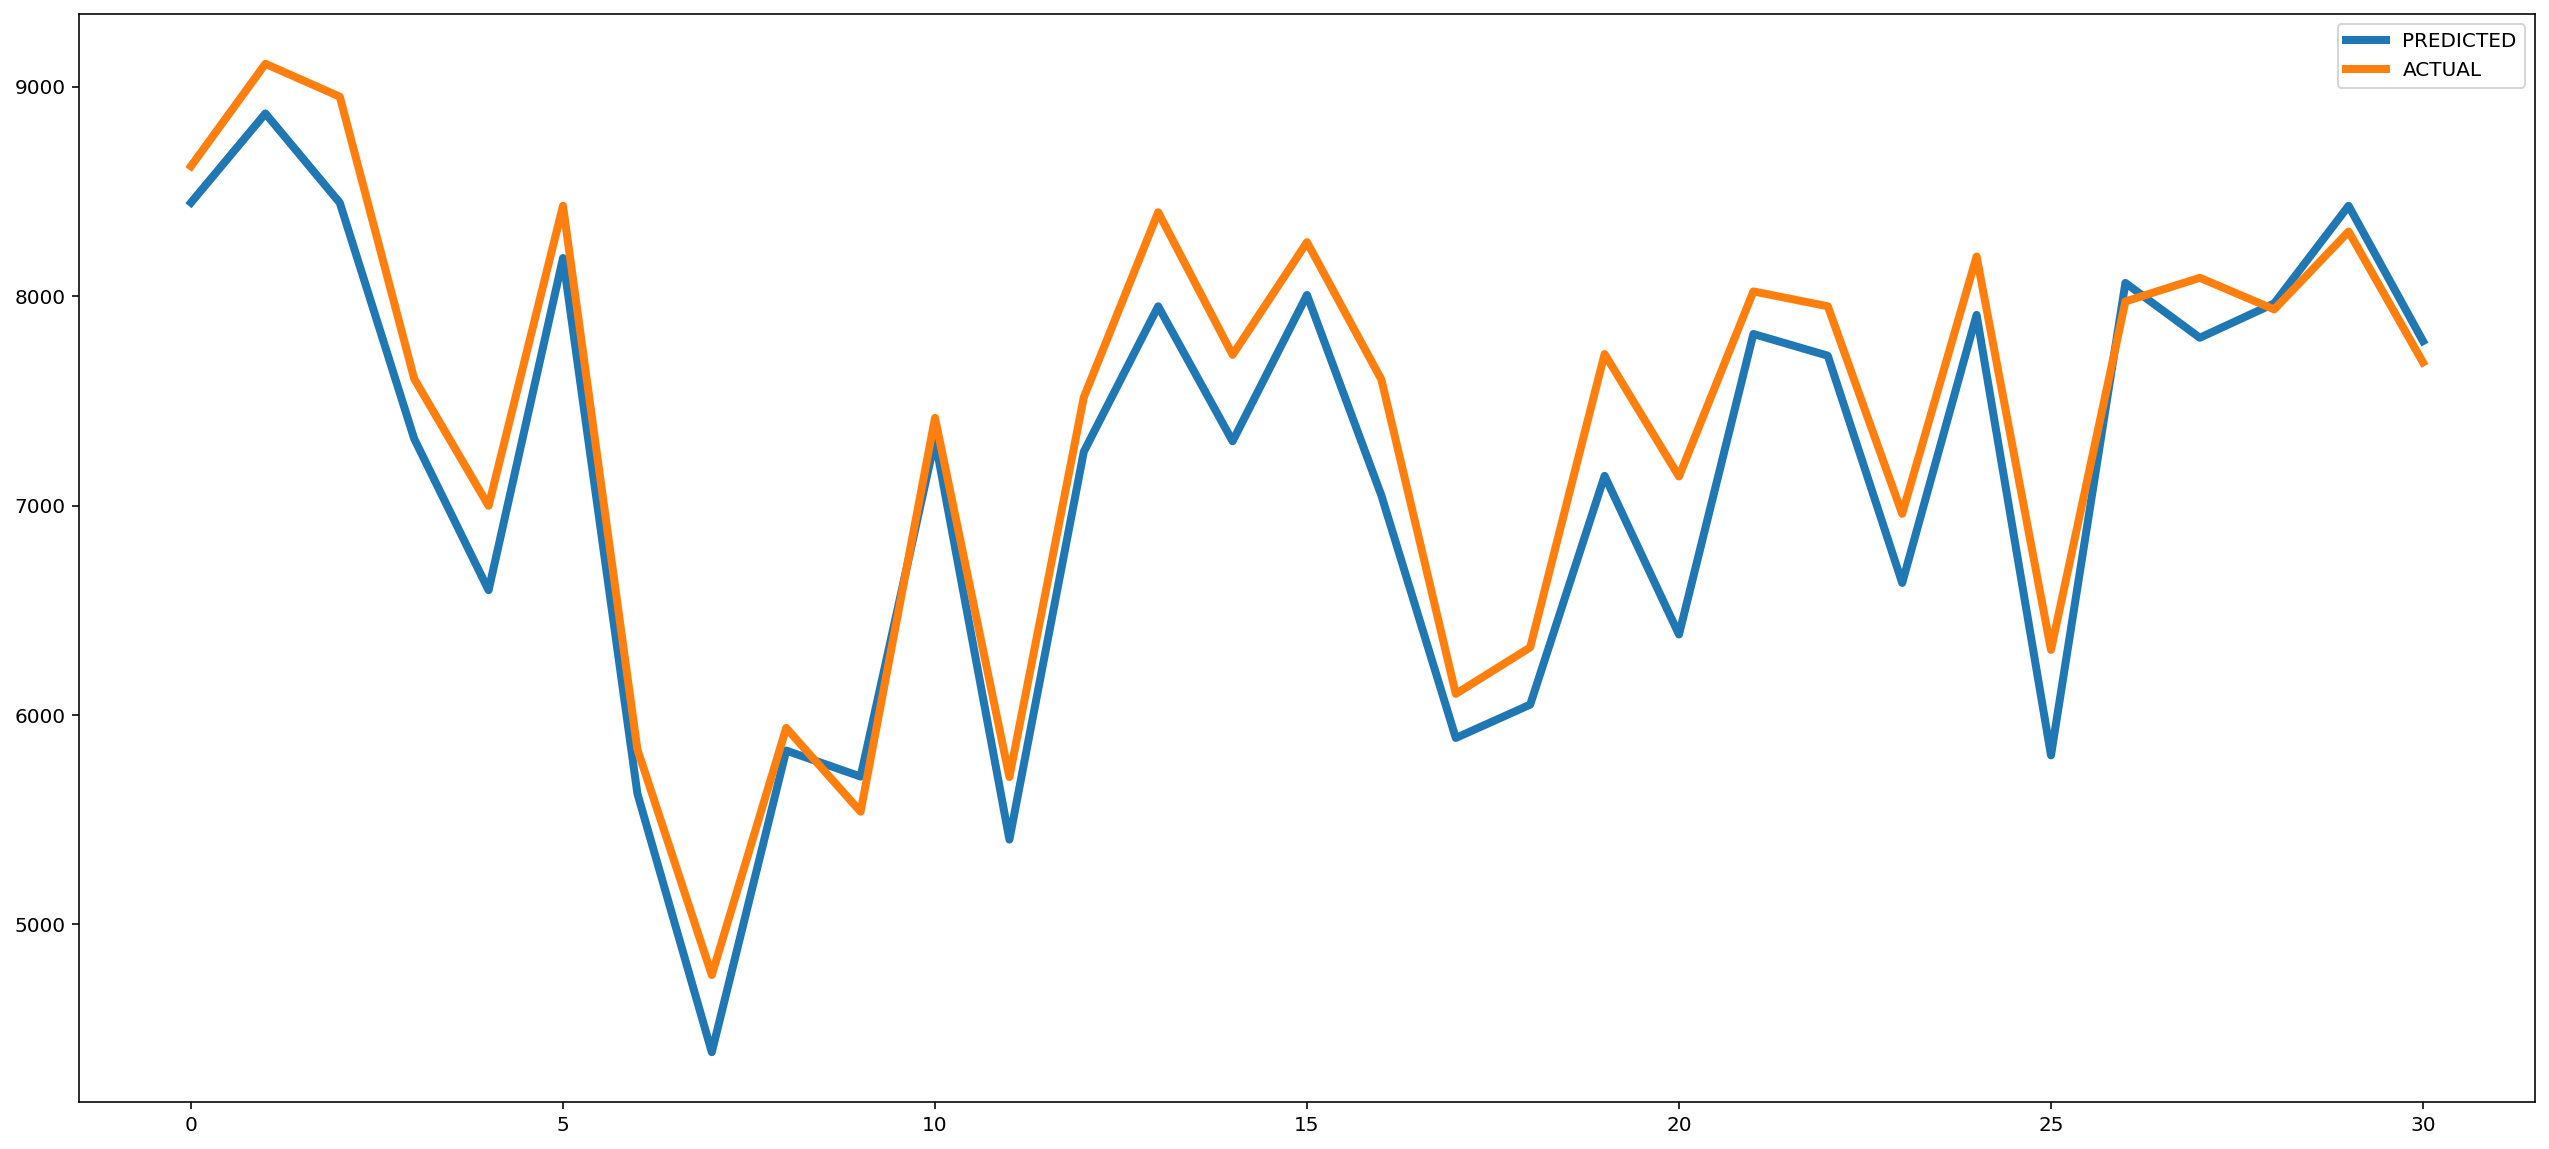

In [70]:
LSTM_MONTH_PLOT('mar',2020)

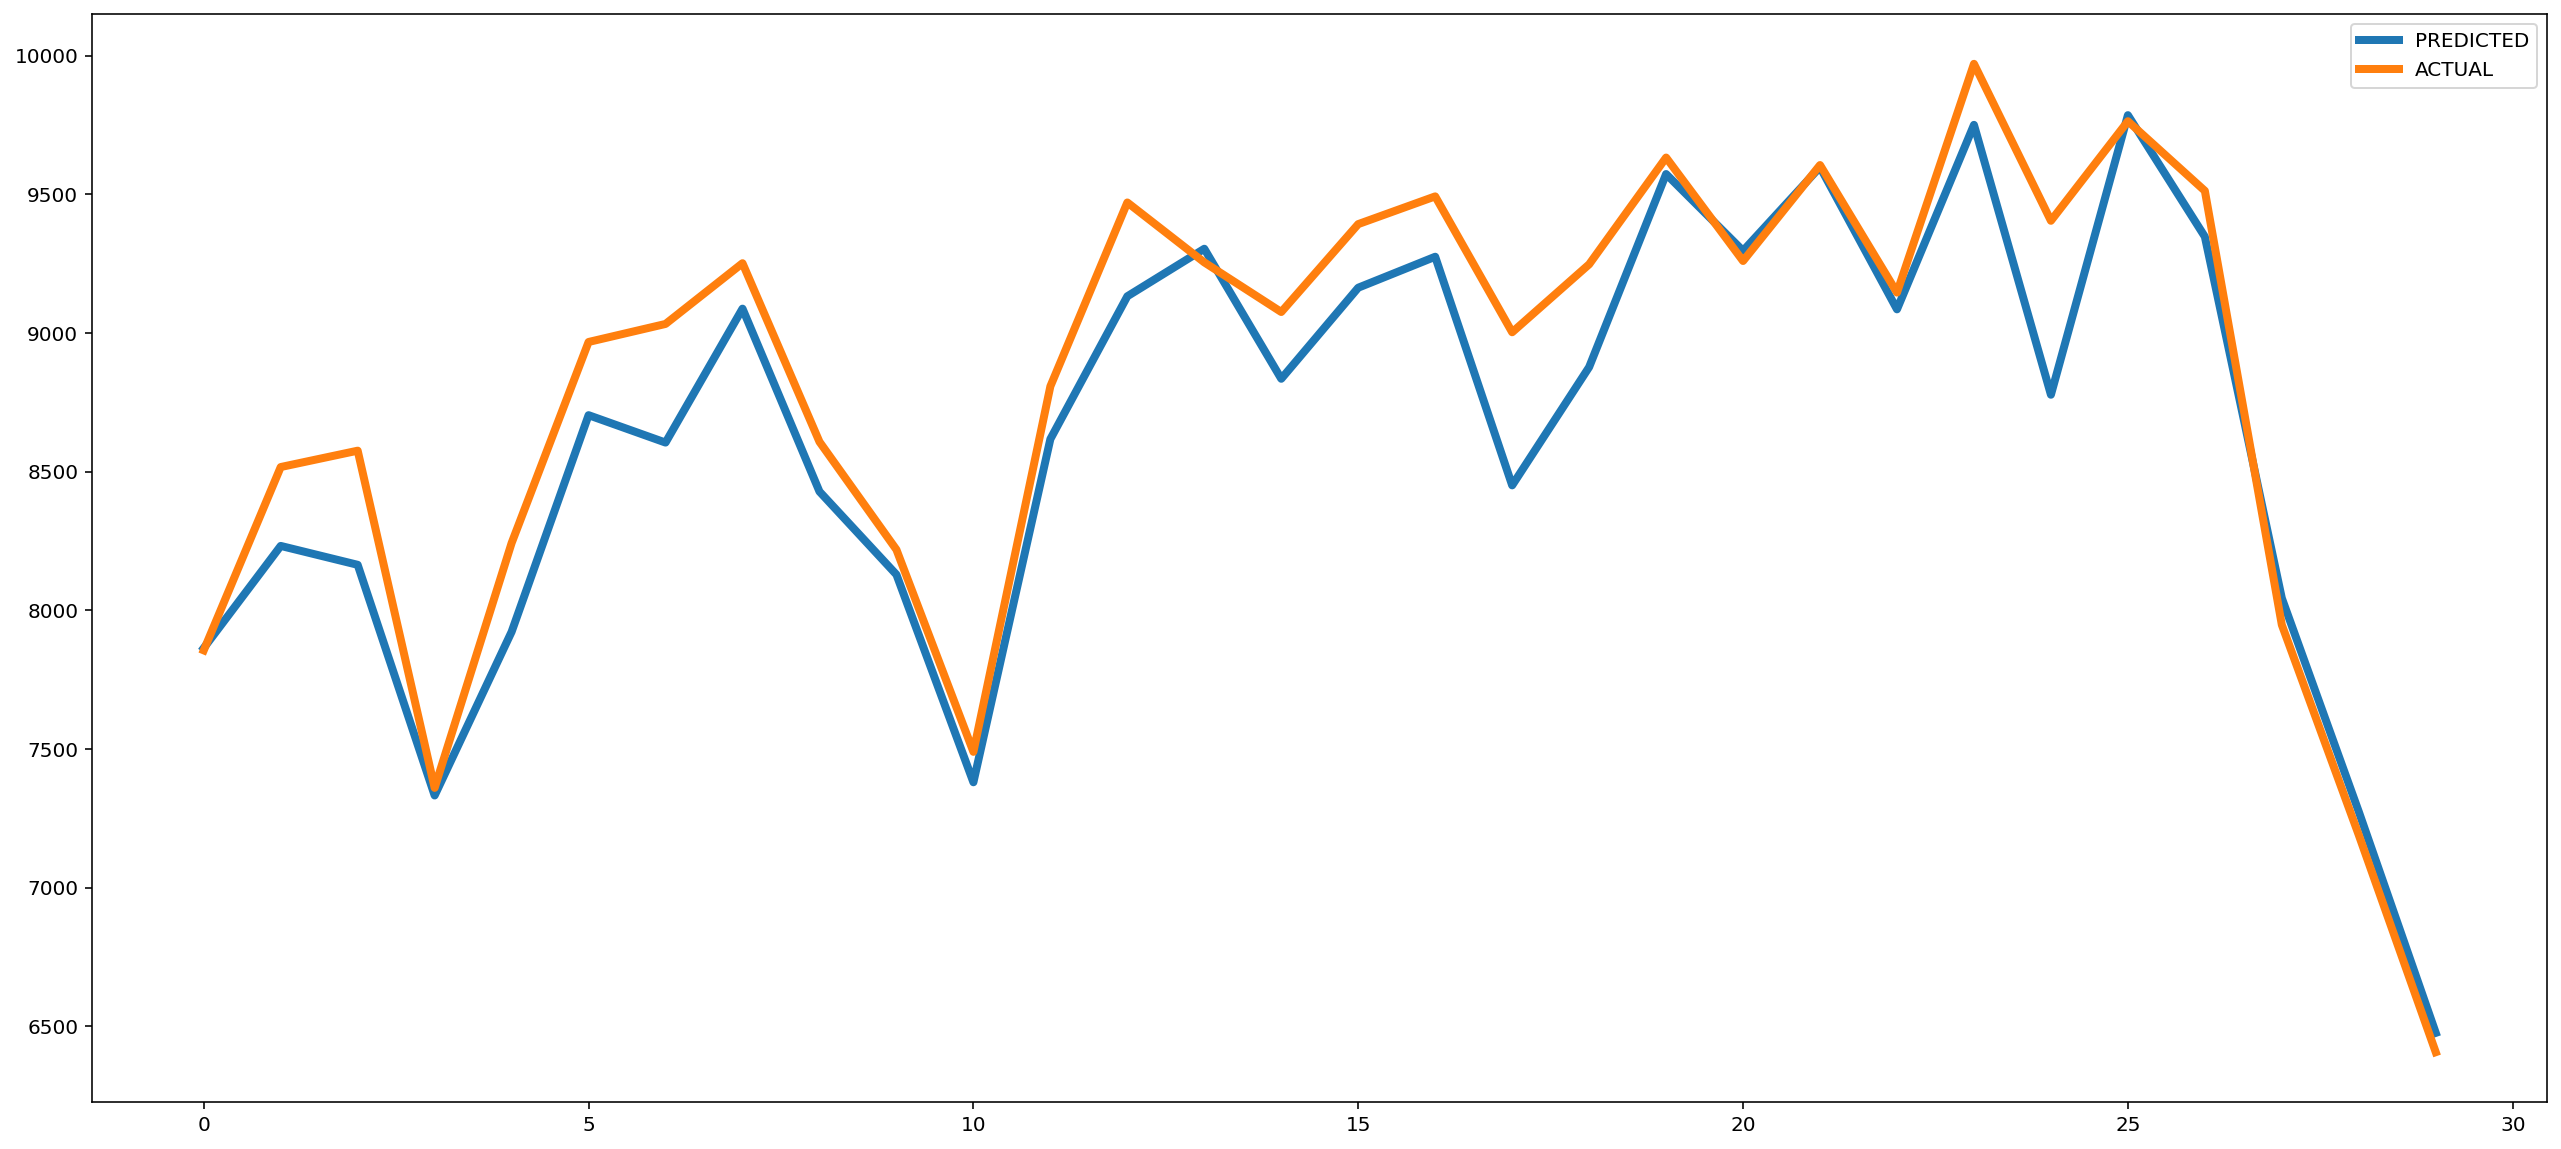

In [71]:
LSTM_MONTH_PLOT('jun',2020)


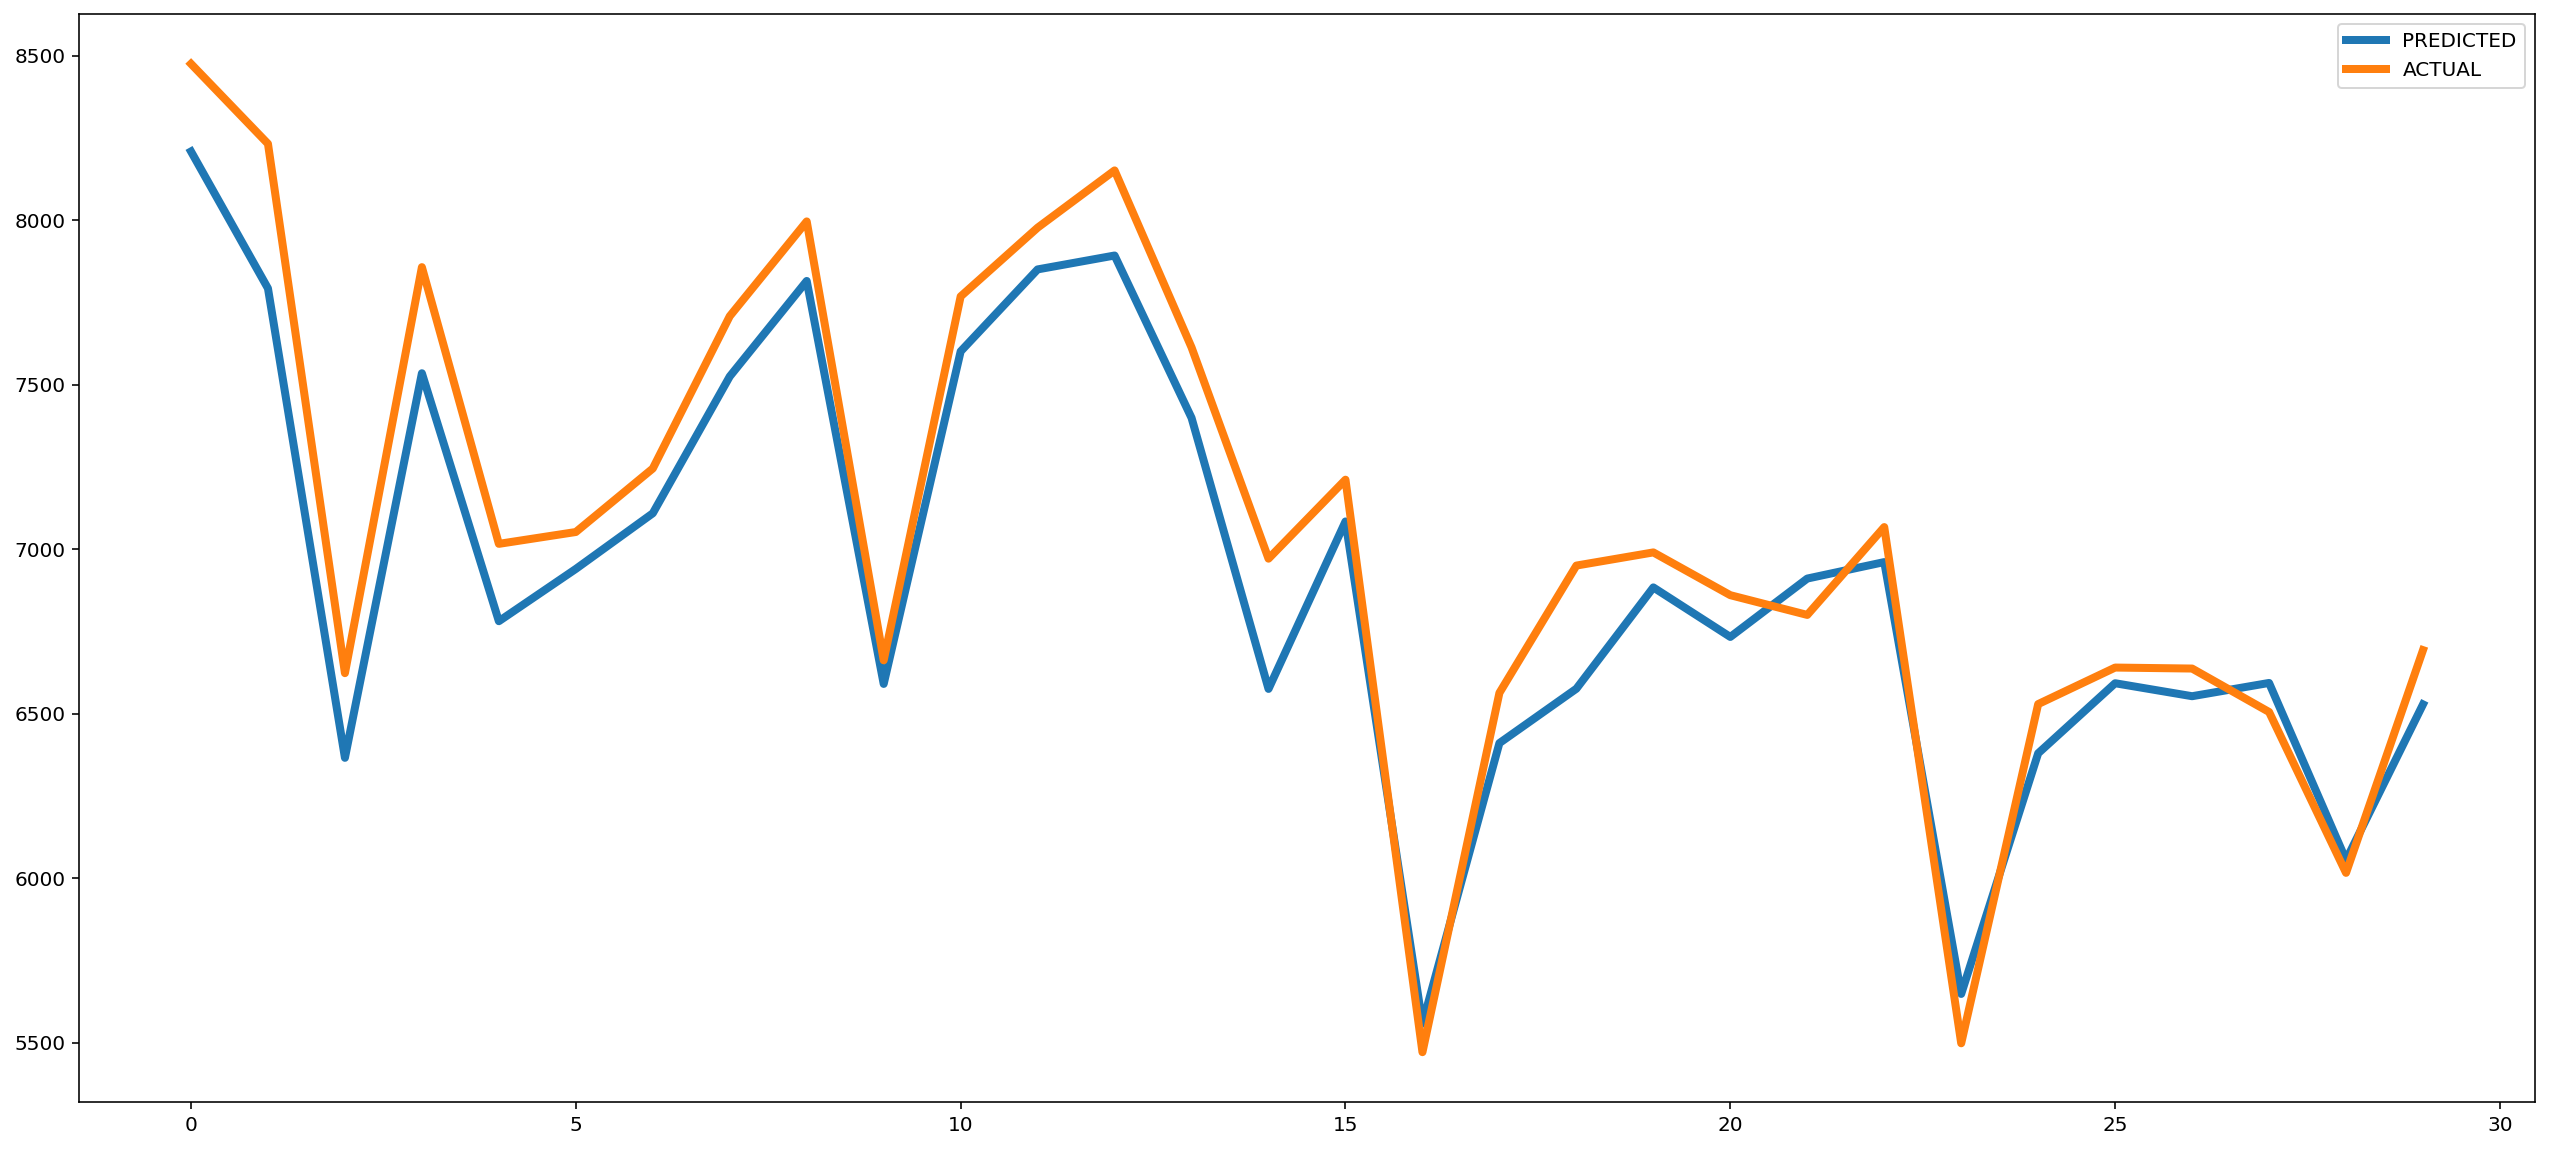

In [72]:
LSTM_MONTH_PLOT('sep',2020)


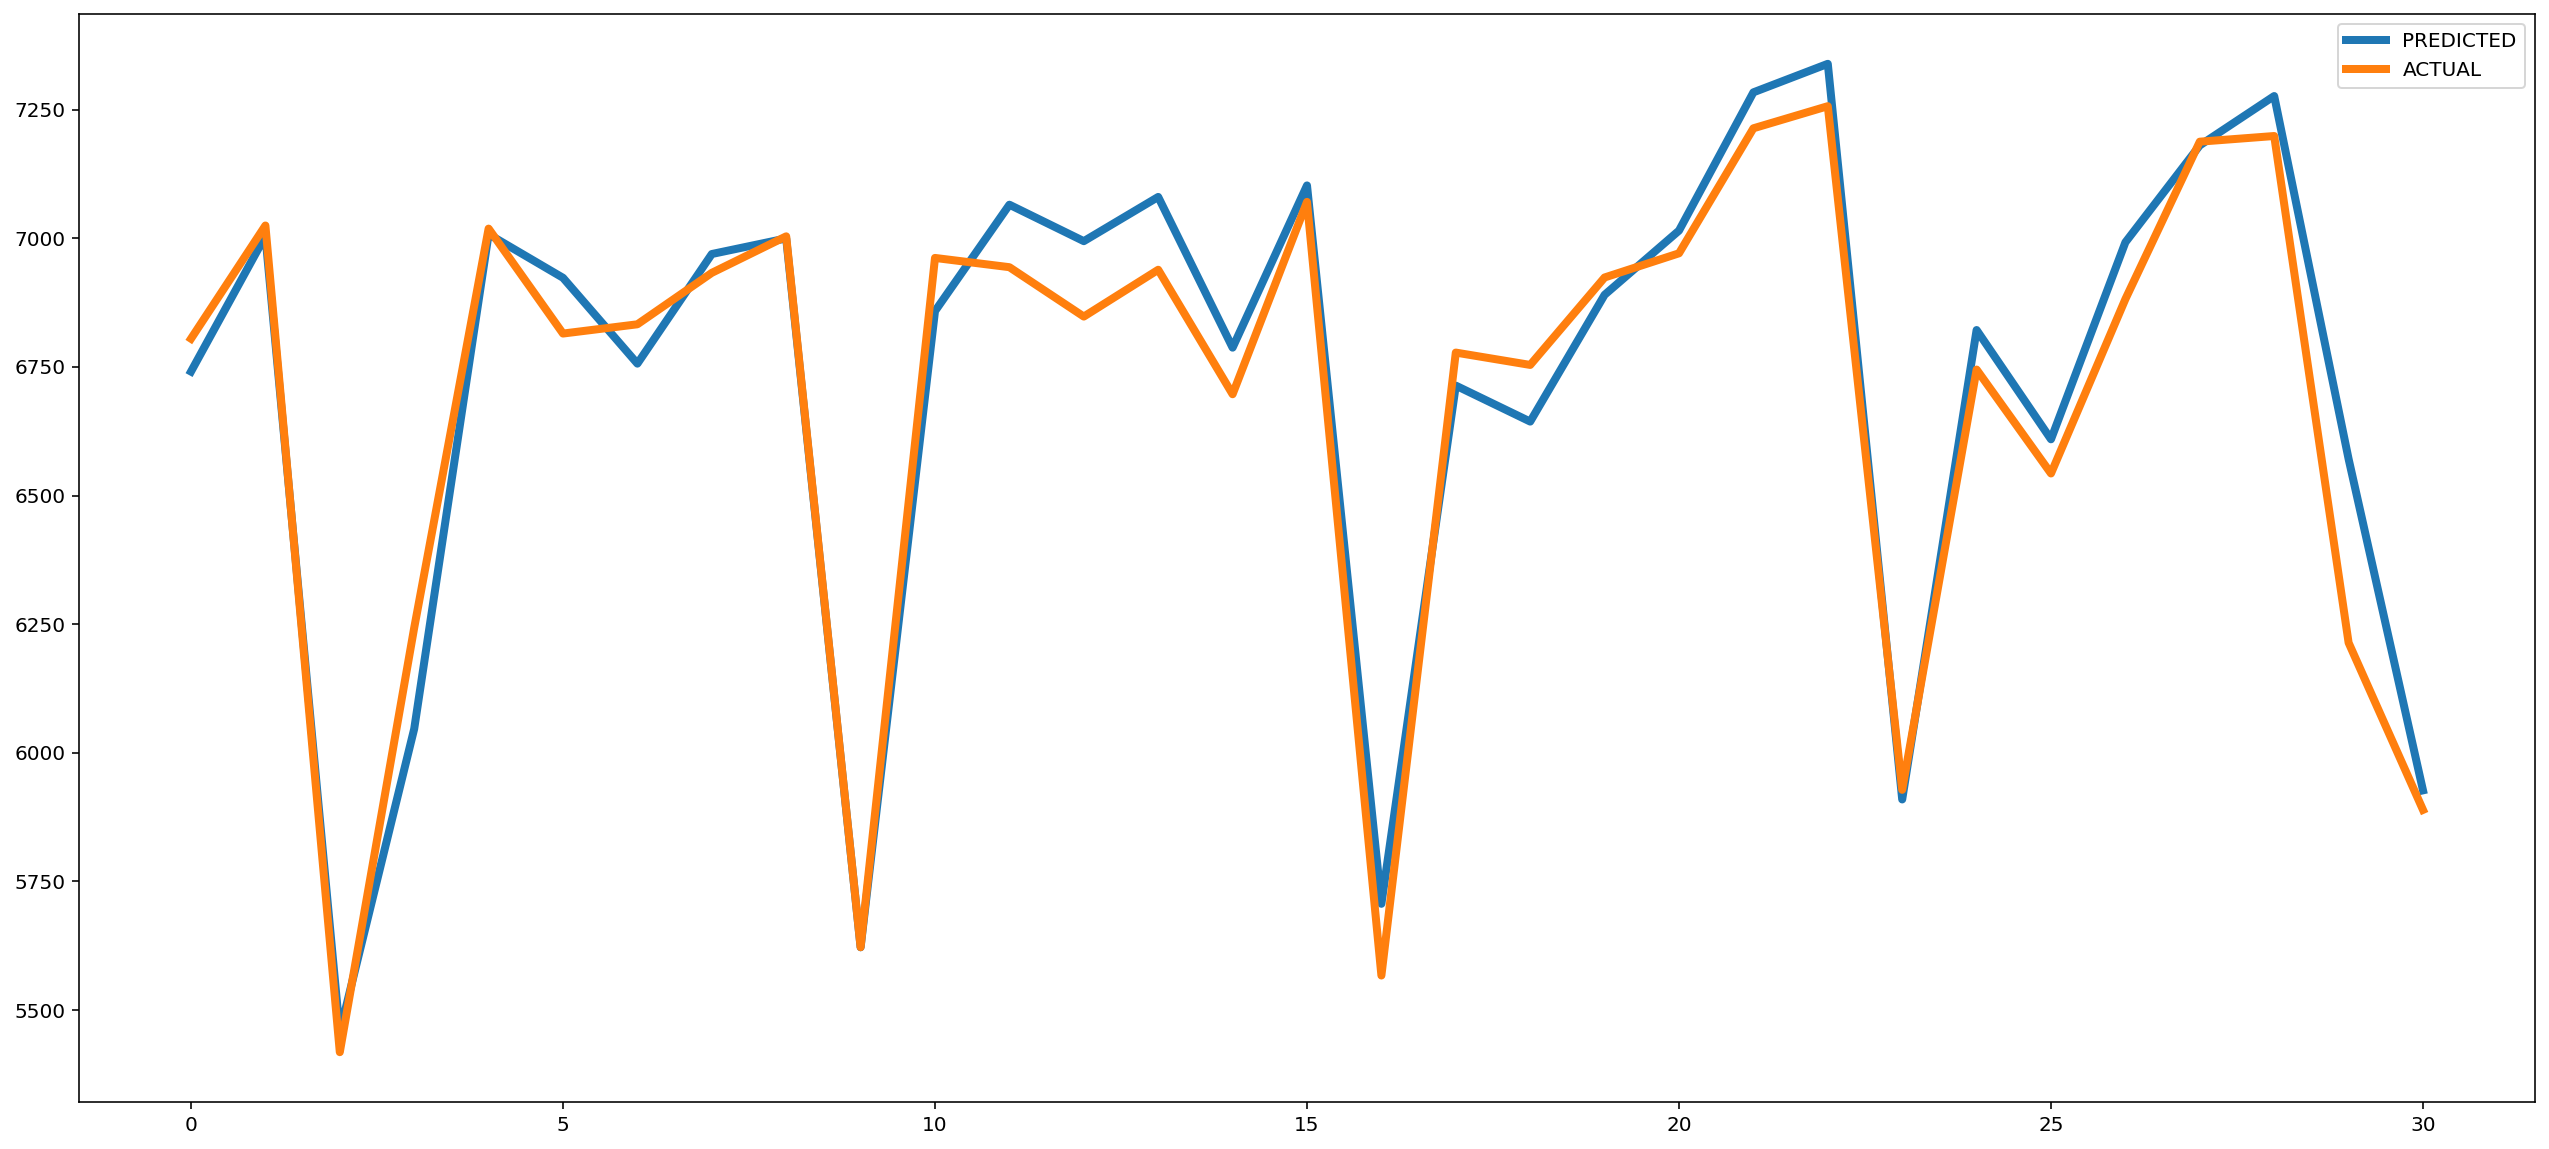

In [73]:
LSTM_MONTH_PLOT('dec',2020)
